# Momentum Transformer

## Strategy Definition(TSMOM)

Time series momentum refers to the tendency of asset prices to continue moving in the same direction as they have in the past over time. This concept is based on the observation that, in financial markets, assets with positive returns over a certain period tend to continue yielding positive returns in the near future, and vice versa for assets with negative returns.

The combined returns of a time series momentum (TSMOM) strategy can be expressed as below – characterised by a trading rule or signal $I_t^{(i)} \in [−1, 1]$:

$$
R^{\text{TSMOM}}_{t+1} = \frac{1}{N}\sum_{i=1}^{N} I_t^{(i)} \frac{\sigma_{\text{tgt}}}{\sigma_{t}^{(i)}} R_{t+1}^{(i)}
$$

where

- $N$ is the number of assets
- $R^{\text{TSMOM}}_{t+1}$ is the realised return of the TSMOM strategy at time $t+1$
- $R_{t+1}^{(i)}$ is the return of $i$-th asset at time $t$
- $I_t^{(i)}$ is the positoin size of $i$-th asset at time $t$
- $\sigma_{\text{tgt}}$ is the target volitility
- $\sigma_{t}$ is the ex-ante volatility, calculated using a 60-day exponentially weighted moving standard deviation

## Problem Statement

The **Transformer** model aims to find the position of an asset with given time series. Here's the formal setup:

- **Inputs Features:** We summarise our model features, ${\bf u}_t^{(i)}$, for each time-step $t$ as,

  - $\left\{ \frac{r^{(i)}_{t,t'}}{\sigma^{(i)}_t \sqrt{t'}} \ | \ t' \in \{1, 21, 63, 126, 252 \} \right\}$, as returns at different timescales, where $r^{(i)}_{t,t'}$ means return with timescale $t'$ at time $t$ (e.g. $r^{(i)}_{t,21}$ is the monthly return at time $t$)
  - $\left\{ M^{(i)}_t(S, L) \ | \ (S, L) \in T \right\}$, as MACD indicators with $T = \{(8, 24), (16, 28), (32, 96)\}$,
  - $\left\{ \nu^{(i)}_t(u), \gamma^{(i)}_t(u) \ | \ t' \in \{21, 126\} \right\}$, as changepoint severity and location at different timescales, if the CPD module is used.

- **Output:** The model predicts $X_{t}^{(i)} \in [-1, 1]$.

- **Function:** Transformer learns a nonlinear mapping $I_{t}^{(i)} = F({\bf u}_{1}^{(i)}, \ldots, {\bf u}_{t}^{(i)})$ to make its predictions.

**Key Idea:** Transformer selectively focuses on certain parts of the input data at different time steps. This selective attention helps it handle complexities and dependencies within the time series.


## Three versions of models:

1. **Encoder-Decoder Transformer**

2. **Decoder-Only Transformer**

3. **Temporal Fusion Transformer**

Before introducing the models, there are some concept we have to know.

## Addintional Components of First Two Models

## Changepoint Detection
### Introduction
Change point detection is a statistical method used to analyze time series data to identify the points at which its statistical properties (such as mean and variance) change. This method is applied in many fields, such as financial market analysis, industrial production quality control, and biological signal processing.

First let’s define the symbols, $r_t=\frac{p_{t}-p_{t-1}}{p_{t-1}}$, we consider the series $\{r_t\}_{t=T-l}^{T}$ , with lookback horizon $l$ from time $T$,  For every CPD window, where $\tau =\{T - l, T - l + 1,…, T\}$, we standardize our returns as
$$
\hat{r_t}=\frac{r_t-E_{\tau}[r_t]}{\sqrt{Var_{\tau}[r_t]}}
$$
### Gaussian Processes Regression
Our approach to changepoint detection involves a curve-fitting approach for input–output pairs $(t,\hat{r_t})$ via the use of GP regression
GP regression is a probabilistic, nonparametric method, popular in the fields of machine learning and time-series analysis. It is a kernel-based technique in which the $GP$ is specified by a covariance function $k_\xi(·)$, which is in turn parameterized by a set of hyperparameters $\xi$.
We define the GP as a distribution over functions where:
$$
\hat{r_t}=f(t)+\epsilon_t\;,\;f\sim GP(0,k_{\xi}),\epsilon_t \sim N(0,\sigma_n^2)
$$
given noise variance $\sigma_n$, which helps to deal with noisy outputs that are uncorrelated.
Matérn 3/2 kernel is a good choice of covariance function for noisy financial data. We parametrize our Matérn 3/2 kernel as
$$
k(x,x^{′})=\sigma_h^2(1+\frac{\sqrt{3}|x-x^{′}|}{\lambda})e^{\frac{\sqrt{3}|x-x^{′}|}{\lambda}}
$$
with kernel hyperparameters $\xi_M=(\lambda,\sigma_h,\sigma_n)$, where λ is the input scale and $\sigma_h$ the output scale.
We define our covariance matrix for a set of locations $x = [x_1, x_2,…x_n]$ as
$$
K(x,x)=\begin{bmatrix}
k(x_1,x_1)&\dots&k(x_1,x_n)\\
\vdots & \ddots &\vdots \\
k(x_n,x_1)&\dots&k(x_n,x_n)
\end{bmatrix}
$$
Using $\mathbf{\hat{r}} = [\hat{r}_{T-l},...,\hat{r}_T]$, we integrate out the function variables to give $p(\mathbf{\hat{r}}|\xi) = N (0,V)$, with $V=K+\sigma_n^2 I$.
perform type II maximum likelihood on $p(\mathbf{\hat{r}}|\xi)$. We minimize the negative log marginal likelihood:
$$
nlml_{\xi}=\min_{\xi}(\frac{1}{2}\mathbf{\hat{r}}^{′}V^{-1}\mathbf{\hat{r}}+\frac{1}{2}\log|V|+\frac{l+1}{2}\log2\pi)
$$
We assumed that our function of interest is well behaved, except for a drastic change, or changepoint, at $c ∈ \{t - l + 1,…, t - 1\}$, after which all observations before $c$ are completely uninformative about the observations after this point. It is important to note that the LBW $l$ for this approach needs to be prespecified, and it is assumed that it contains a **single changepoint**.The region-switching kernel is
$$
k_{\xi_R}(x,x^{′})=\begin{cases}
k_{\xi_1}(x,x^{′}) & x,x^{′}<c\\
k_{\xi_2}(x,x^{′}) & x,x^{′}\geq c\\
0 &\text{otherwise}
\end{cases}
$$
with a full set of hyperparameters $\xi_R = \{\xi_1, \xi_2, c,\sigma_n\}$. 
approximate the abrupt change of covariance
in last equation using a sigmoid function $\sigma(x) = 1/(1 + e^{−s(x−c)})$, which has the properties $\sigma(x, x^{′}) = \sigma(x)\sigma(x^{′})=\bar{\sigma}(x, x^{′})(1 - \sigma(x))(1 - \sigma(x^{′}))$.
Here, $c ∈ (t - l, t)$ is the changepoint location, and $s > 0$ is the steepness parameter. Our changepoint kernel is
$$
k_{\xi_C}(x,x^{′})=k_{\xi_1}(x,x^{′})\sigma(x, x^{′})+k_{\xi_2}(x,x^{′})\bar{\sigma}(x, x^{′})
$$
with a full set of hyperparameters $\xi_C = \{\xi_1, \xi_2, c, s,\sigma_n\}$. We can compute $nlml_{ξ_C}$ by optimizing the parameters a single GP more efficient.
To quantify the level of disequilibrium, we look at the reduction in negative log marginal likelihood achieved via the introduction of the changepoint kernel hyperparameters through comparison to $nlml_{\xi_M}$. If the introduction of additional hyperparameters leads to no reduction in negative log marginal likelihood, then the level of disequilibrium is low.
Our changepoint score $\nu_t \in (0,1)$ and location $\gamma_t \in (0,1)$ are
$$
\nu_t=1-\frac{1}{1+e^{-(nlmn_{\xi_C}-nlmn_{\xi_M})}}\;,\;\gamma_t=\frac{c-(t-l)}{l}
$$
which are both normalized values, which helps to improve stability and performance of our LSTM module.

## Positional Encoding

### Introduction

In certain situations, the order of data is crucial. For instance, the sentences "The dog is cute but the cat is not" and "The cat is cute but the dog is not" convey entirely different meanings, just as the trading signals for 3 assets [1, -1, 1] and [-1, 1, 1] differ significantly. Therefore, it is important to find a method that provides positional information without complicating the model or increasing its dimensionality.

### Motivation

In the transformer model, the core mechanism is Attention. However, there's a significant limitation with Attention: it does not inherently consider the position information. This means that the order of the input vector does not naturally influence the output, which poses a substantial challenge when dealing with time-series data. To address this, positional encoding is employed to incorporate sequence information, ensuring that the model can account for the temporal order of events, which is crucial in time-series analysis.

### Architecture

Positional Encoding offers an effective solution by providing the position information of each data point in a sequence without increasing the complexity or dimensionality of the model. This is achieved by directly adding the positional encoding to the representation of the data (e.g., word embeddings). The architecture of positional encoding is defined as follows:

$$
\begin{cases}
\text{PE}_{({\it pos},2i)} = sin({\it pos}/10000^{(2i/d_{\text{model}})})
\\
\text{PE}_{({\it pos},2i+1)} = cos({\it pos}/10000^{(2i/d_{\text{model}})})
\end{cases}
$$

where $pos$ is the position, $i$ is the index of embedding vector, and $d_{\text{model}}$ is the dimension of embedding vector.


### How Positional Encoding Keeps Position Information

Positional encodings designed in this way enable the model to directly reflect the relative positional relationship between any two locations in a sequence. This is because when you move a fixed distance $k$ from one position to another, the properties of sine and cosine functions allow this movement to be represented linearly through the encoding of the original position. 

In other words, for any given offset $k$, the positional encoding at position $pos+k$ can be predicted through some linear transformation of the encoding at position $pos$, allowing the model to easily "understand" the relative positions of elements within the sequence by learning this transformation.

when we consider the positional encoding at position $pos + k$:

$$
\begin{cases}
\text{PE}_{({\it pos+k},2i)} = sin(\frac{\it pos+k}{10000^{(2i/d_{\text{model}})}})
\\
\text{PE}_{({\it pos+k},2i+1)} = cos(\frac{\it pos+k}{10000^{(2i/d_{\text{model}})}})
\end{cases}
$$

by Trigonometric Identity we have

$$
\begin{align*}
\text{PE}_{({\it pos+k},2i)} &= sin(\frac{\it pos+k}{10000^{(2i/d_{\text{model}})}})
\\
&= sin(\frac{\it pos}{10000^{(2i/d_{\text{model}})}} + \frac{k}{10000^{(2i/d_{\text{model}})}})
\\
&= sin(\frac{\it pos}{10000^{(2i/d_{\text{model}})}})cos(\frac{k}{10000^{(2i/d_{\text{model}})}}) + cos(\frac{\it pos}{10000^{(2i/d_{\text{model}})}})sin(\frac{k}{10000^{(2i/d_{\text{model}})}})
\\
&= \text{PE}_{({\it pos},2i)}cos(\frac{k}{10000^{(2i/d_{\text{model}})}}) + \text{PE}_{({\it pos},2i+1)}sin(\frac{k}{10000^{(2i/d_{\text{model}})}})
\end{align*}
$$

Since $i$, $k$ and $d_{\text{model}}$ are given, we see that $\text{PE}_{({\it pos+k},2i)}$ is a linear function of $\text{PE}_{({\it pos},2i)}$, $\text{PE}_{({\it pos},2i+1)}$

by the similar argument:

$$
\begin{align*}
\text{PE}_{({\it pos+k},2i+1)} &= cos(\frac{\it pos+k}{10000^{(2i/d_{\text{model}})}})
\\
&= cos(\frac{\it pos}{10000^{(2i/d_{\text{model}})}} + \frac{k}{10000^{(2i/d_{\text{model}})}})
\\
&= cos(\frac{\it pos}{10000^{(2i/d_{\text{model}})}})cos(\frac{k}{10000^{(2i/d_{\text{model}})}}) - sin(\frac{\it pos}{10000^{(2i/d_{\text{model}})}})sin(\frac{k}{10000^{(2i/d_{\text{model}})}})
\\
&= \text{PE}_{({\it pos},2i+1)}cos(\frac{k}{10000^{(2i/d_{\text{model}})}}) - \text{PE}_{({\it pos},2i)}sin(\frac{k}{10000^{(2i/d_{\text{model}})}})
\end{align*}
$$

which means $\text{PE}_{({\it pos+k},2i+1)}$ is also a linear function of $\text{PE}_{({\it pos},2i)}$, $\text{PE}_{({\it pos},2i+1)}$

This approach enables the model to effectively recognize the sequence order, as the differences in positional encoding follow a consistent pattern. This regularity in the positional differences facilitates the model's understanding of sequence positioning, contributing to its ability to accurately capture the sequence's inherent order.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import numpy as np
from datetime import timedelta, datetime
import datetime as dt
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from pybit.unified_trading import HTTP
import time 

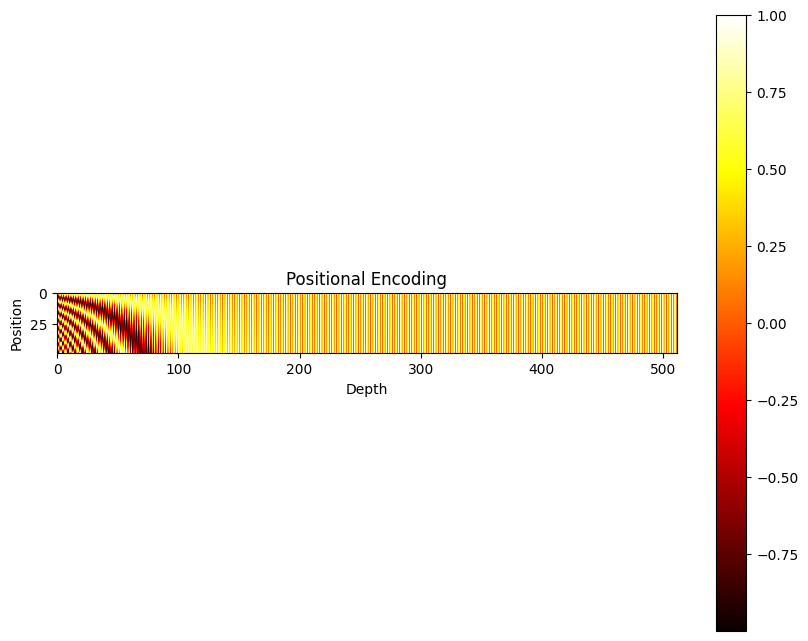

In [2]:
def positional_encoding(position, d_model):
    """
    Generates positional encoding for a given sequence length and dimensionality.
    
    Args:
    - position (int): The sequence length.
    - d_model (int): The dimensionality of the model/output embeddings.
    
    Returns:
    - pos_encoding (numpy.ndarray): The positional encoding matrix.
    """
    # Initialize the positional encoding matrix
    pos_encoding = np.zeros((position, d_model))
    
    # Compute the positional encoding values
    for pos in range(position):
        for i in range(0, d_model, 2):
            pos_encoding[pos, i] = np.sin(pos / (10000 ** ((2 * i) / d_model)))
            if i + 1 < d_model:
                pos_encoding[pos, i + 1] = np.cos(pos / (10000 ** ((2 * (i + 1)) / d_model)))
    
    return pos_encoding

position = 50  # Sequence length
d_model = 512  # Dimensionality

pos_encoding = positional_encoding(position, d_model)

# Visualize the positional encoding
plt.figure(figsize=(10, 8))
plt.imshow(pos_encoding, cmap='hot')
plt.colorbar()
plt.xlabel('Depth')
plt.ylabel('Position')
plt.title('Positional Encoding')
plt.show()


## Embedding

### Introduction

The Embedding is a component in deep learning models that is used to represent categorical or discrete data as continuous vectors. These vectors, also known as embeddings, capture the relationships and similarities between different categories or classes. The Embedding is commonly used in natural language processing tasks, such as text classification or language translation, where words or tokens need to be represented as continuous values.

### Why We Need Embedding

1. **Dimensionality Reduction**

    **Problem**: Many types of data, especially words in text processing or categorical variables in general, are initially represented in high-dimensional, sparse formats that are inefficient for machine learning models to process.

    **Solution**: Embeddings reduce the dimensionality of these representations, making the data more manageable for models while preserving essential information.

2. **Capture Relationship**

    **Problem**: In original datas, it's hard to understand the relationship between the datas.

    **Solution**: Embeddings are designed to place similar items closer together in the vector space, which means that the distance between vectors conveys semantic relationships (e.g., synonyms have vectors that are closer together).

### Architecture

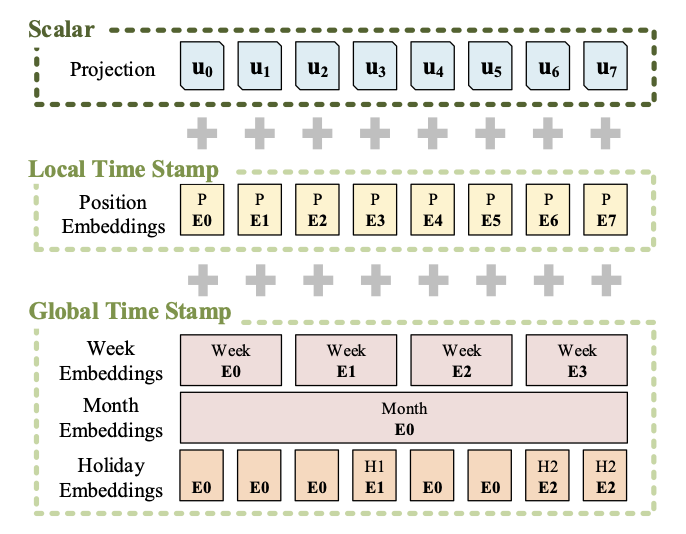

$$
\text{Embedding}(x) = \alpha(Wx+b) + \text{Positional Encodeing}(x) + \sum_{q} \text{Stamp Embedding}_{q}(x)
$$

where 

- $q$ is the number of types of global time stamps
- $W \in \mathbb{R}^{n \times p}$, $b \in \mathbb{R}^p$ are parameters to learn 



## 1. Encoder-Decoder Transformer

### Architecture

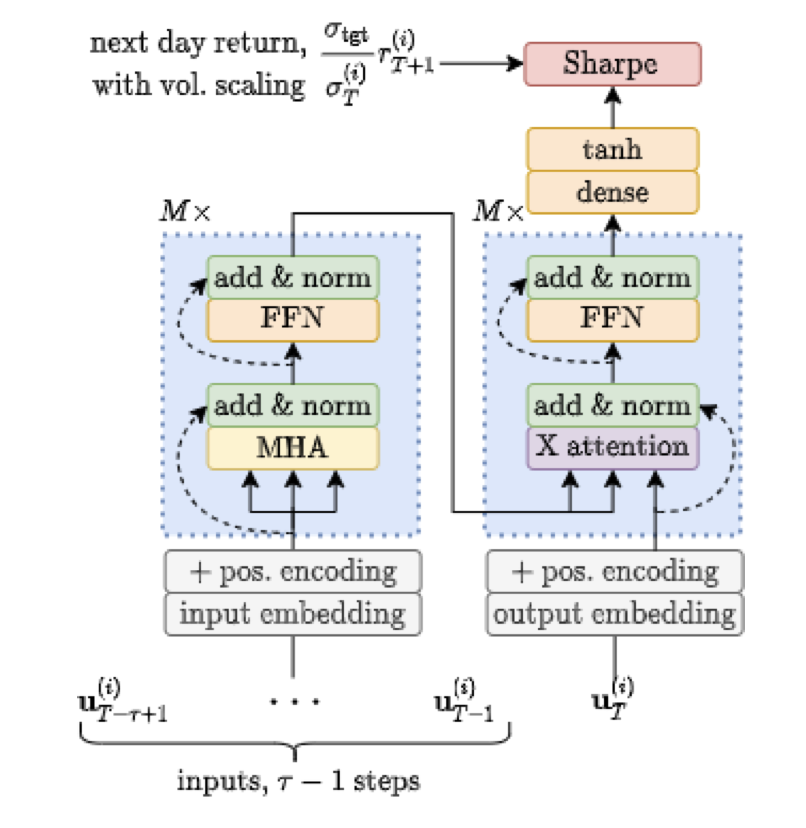

### Feed-Foward Network(FFN)

The Feed-forward Network (FFN), which is used in all architectures, consists of a learnable linear transformation, or dense layer, followed by a Rectified Linear Unit (ReLU) activation function $\max(.,0)$, to introduce non-linearity, then another learnable linear transformation. We summarise the FFN as,

$$
\text{FFN}(x_t) = W_2 \text{ReLU}(W_1 x_t + b_1) + b_2,
$$

where

- $W_i$, $b_i$ is the learnable parameters

### Encoder

Let $X = \left( x_t^{(i)} \right)_{t=1}^{T-1}$ be the embedded and postitional encoded inputs of encoder, and $Y = \left( y_t^{(i)} \right)_{t=1}^{T-1}$ be the encoder output

$$
Y = (\text{Enc}_M \circ \cdots \circ \text{Enc}_1)(X)
$$
$$
\text{Enc}_i(X) = \phi(X' + \delta(\text{FFN}(X')))
$$
$$
X' = \phi(X + \delta(\text{MHA}(X)))
$$

where

- $\text{MHA}$ is the Multi-Head Attention.
- $\delta(\cdot)$ is the dropout to prevent overfitting.
- $\phi(\cdot)$ is the layer normalization which normalises to 0 mean and 1 standard deviation.
- $M$ is the number of encoder layer.

### Decoder
 
Let $\tilde{Z} = \tilde{z}_T^{(i)}$ be the embedded and postitional encoded inputs of decoder, and $Z = \left( z_t^{(i)} \right)_{t=1}^{T}$ be the decoder output

$$
Z = (\text{Dec}_{Y,M} \circ \cdots \circ \text{Dec}_{Y,1})(\tilde{Z})
$$
$$
\text{Dec}_{Y,i}(\tilde{Z}) = \phi(\tilde{Z}' + \delta(\text{FFN}(\tilde{Z}')))
$$
$$
\tilde{Z}' = \phi(\tilde{Z} + \delta(\text{XA}_Y(\tilde{Z})))
$$

- $\text{XA}_Y$ is the Cross Attention with the input $Y$ from encoder.
- $\delta(\cdot)$ is the dropout to prevent overfitting.
- $\phi(\cdot)$ is the layer normalization which normalises to 0 mean and 1 standard deviation.
- $M$ is the number of decoder layer.

### Output

The output of the model is the position $I_T^{(i)} \in [-1, 1]$ of assets $i$ at time $T$:

$$
I_T^{(i)} = \tanh(W_d Z + b_d )
$$

where

- $W_d$, $b_d$ is the learnable parameters of dense layer.

### Loss Function

The loss function used in this model is sharpe loss function, while we want to maximize the sharpe ratio, hence the sharpe loss function is defined as the negative of sharpe ratio.

$$
\mathcal{L}_{\text{sharpe}}(\Omega; \theta) = -\frac{\sqrt{252} \mathbb{E}_{\Omega}\left[R_t^{(i)}\right]}{\sqrt{\operatorname{Var}_{\Omega}\left[R_t^{(i)}\right]}}
$$

where

- $\theta$ is the model parameter.
- $\Omega$ is the set of all asset-time pairs in the minibatch.
  (i.e. $\Omega = \{ \frac{\sigma_{\text{tgt}}}{\sigma_{1}} r_1^{(1)} \cdots \frac{\sigma_{\text{tgt}}}{\sigma_{T}} r_T^{(1)} \cdots \frac{\sigma_{\text{tgt}}}{\sigma_{1}} r_1^{(N)} \cdots \frac{\sigma_{\text{tgt}}}{\sigma_{T}} r_T^{(N)} \}$)

- $R_t^{(i)}$ is the volitility scaled return captured by model of asset $i$ at time $t$.

  (i.e. $R_t^{(i)} = I_t^{(i)} \frac{\sigma_{\text{tgt}}}{\sigma_{t}^{(i)}} R_{t}^{(i)}$)


## Code Implementation

## Model Construction

In [3]:
class Embedding(nn.Module):
    """
    Embedding
    input_size: dim of input_data
    embedding_size = embedding_size
    """
    def __init__(self, input_size, embedding_size):
        super(Embedding, self).__init__()
        self.embedding = nn.Linear(in_features = input_size, out_features = embedding_size, bias=False)
        
    def forward(self, input_seq):
        embedd = self.embedding(input_seq)
        return embedd
    
class Positional_Encodeing(nn.Module):
    """
    Positional_Encoding
    T: seq_length
    embedding_size = embedding_size
    """
    def __init__(self, embedding_size, T,batch_first=True):
        super(Positional_Encodeing, self).__init__()
        self.batch_first=batch_first
        self.embedding_size = embedding_size
        self.T = T
        
    def forward(self, embedd):
        pos_encoding = np.zeros((self.T, self.embedding_size))# (Sequence length, Dimensionality)
        # Compute the positional encoding values
        for pos in range(self.T):
            for i in range(0, self.embedding_size, 2):
                pos_encoding[pos, i] = np.sin(pos / (10000 ** ((2 * i) / self.embedding_size)))
                if i + 1 < embedd.size(1):
                    pos_encoding[pos, i + 1] = np.cos(pos / (10000 ** ((2 * (i + 1)) / self.embedding_size)))
        
        if self.batch_first and len(embedd.size())==3:
            result = embedd[:,] + torch.tensor(pos_encoding, dtype = torch.float)
            
            # t = 1,...,T-1 is encoder_input
            # t = T is decoder_input
            encoder_input = result[:,:-1]
            decoder_input = result[:,-1:]
        else:
            result = embedd + torch.tensor(pos_encoding, dtype = torch.float)
            
            # t = 1,...,T-1 is encoder_input
            # t = T is decoder_input
            encoder_input = result[:-1]
            decoder_input = result[-1:]
        return encoder_input, decoder_input

class Encoder(nn.Module):
    """
    Encoder
    embedding_size: embedding_size
    d_encoder: dim of feature size in encdoer
    num_heads: number of heads of multihead attention
    dropout: dropout value to prevant overfitting
    """
    def __init__(self, embedding_size, d_encoder, num_heads, dropout):
        super(Encoder, self).__init__()
        self.q = nn.Linear(in_features = embedding_size, out_features = d_encoder)
        self.k = nn.Linear(in_features = embedding_size, out_features = d_encoder)
        self.v = nn.Linear(in_features = embedding_size, out_features = d_encoder)
        self.MHA = nn.MultiheadAttention(embed_dim=d_encoder, num_heads=num_heads,batch_first=True)
        self.ffn1 = nn.Linear(in_features = d_encoder, out_features = d_encoder)
        self.ffn2 = nn.Linear(in_features = d_encoder, out_features = d_encoder)
        self.layer_norm = nn.LayerNorm(d_encoder)
        self.dropout = nn.Dropout(dropout)
        self.Relu = nn.ReLU()
        
    def forward(self, encoder_input):
        # query, key, value construction
        q = self.q(encoder_input)
        k = self.k(encoder_input)
        v = self.v(encoder_input)
        # MHA + add & norm
        e1_outputs, e1_weights = self.MHA(q, k, v)
        e2 = self.layer_norm(self.dropout(e1_outputs) + encoder_input)
        # FFN + add & norm
        encoder_output = self.layer_norm(self.dropout(self.ffn2(self.Relu(self.ffn1(e2)))) + e2)
        return encoder_output
    
class Decoder(nn.Module):
    """
    Decoder
    embedding_size: embedding_size
    d_encoder: dim of feature size in encdoer
    d_decoder: dim of feature size in decdoer
    num_heads: number of heads of multihead attention
    dropout: dropout value to prevant overfitting
    """
    def __init__(self, embedding_size, d_encoder, d_decoder, num_heads, dropout):
        super(Decoder, self).__init__()
        self.q = nn.Linear(in_features = embedding_size, out_features = d_decoder)
        self.k = nn.Linear(in_features = d_encoder, out_features = d_decoder)
        self.v = nn.Linear(in_features = d_encoder, out_features = d_decoder)
        self.XMHA = nn.MultiheadAttention(embed_dim=d_decoder, num_heads=num_heads,batch_first=True)
        self.ffn1 = nn.Linear(in_features = d_decoder, out_features = d_decoder)
        self.ffn2 = nn.Linear(in_features = d_decoder, out_features = d_decoder)
        self.layer_norm = nn.LayerNorm(d_decoder)
        self.dropout = nn.Dropout(dropout)
        self.Relu = nn.ReLU()
        
    def forward(self, encoder_output, decoder_input):
        # query, key, value construction
        q = self.q(decoder_input)
        k = self.k(encoder_output)
        v = self.v(encoder_output)
        # XMHA + add & norm
        d1_outputs, d1_weight = self.XMHA(q,k,v)
        d2 = self.layer_norm(self.dropout(d1_outputs) + decoder_input)
        # FFN + add & norm
        decoder_output = self.layer_norm(self.dropout(self.ffn2(self.Relu(self.ffn1(d2)))) + d2)
        return decoder_output
    
class ED_Transformer(nn.Module):
    """
    ED_Transformer
    M: number of encoder layer
    N: number of decoder layer
    embedding_size: embedding_size
    d_encoder: dim of feature size in encdoer
    d_decoder: dim of feature size in decdoer
    num_heads: number of heads of multihead attention
    dropout: dropout value to prevant overfitting
    """
    def __init__(self, M, N, input_size, embedding_size, d_encoder, d_decoder, num_heads, dropout, T):
        super(ED_Transformer, self).__init__()
        self.encoders = []
        for _ in range(M):
            self.encoders.append(Encoder(embedding_size, d_encoder, num_heads, dropout))
        self.decoders = []
        for _ in range(N):
            self.decoders.append(Decoder(embedding_size, d_encoder, d_decoder, num_heads, dropout))
        self.embedding = Embedding(input_size, embedding_size)
        self.positional_encoding = Positional_Encodeing(embedding_size, T)
        self.dense = nn.Linear(in_features = d_decoder, out_features = 1)
        self.tanh = nn.Tanh() 
        
    def forward(self, input_seq):
        embedded_input = self.embedding(input_seq)
        encoder_result, decoder_result = self.positional_encoding(embedded_input)
        # Encoder stacked M times
        for encoder in self.encoders:
            encoder_result = encoder(encoder_result)
        # Decoder stacked N times
        for decoder in self.decoders:
            decoder_result = decoder(encoder_result, decoder_result)
        # dense + tanh
        res = self.dense(decoder_result)
        pos = self.tanh(res)
        return pos.squeeze()

class SharpeLoss(nn.Module):
    def __init__(self):
        super(SharpeLoss).__init__()
        
    def forward(self, model_output, target):
        # model output size(batch_size, N)
        # target size(batch_size, N)
        mu_R = torch.sum(model_output*target)/(target.numel())
        p = mu_R * torch.sqrt(torch.tensor(365.0))
        q = torch.sqrt(torch.var(model_output*target,dim=None))
        return -p/q
    
ED_Transformer_model = ED_Transformer(3, 3, 2, 64, 64, 64, 4, 0.1, 63)
ED_Transformer_model_CPD = ED_Transformer(3, 3, 4, 64, 64, 64, 4, 0.1, 63)
criterion = SharpeLoss()
optimizer_ED = torch.optim.Adam(ED_Transformer_model.parameters(), 0.001)
optimizer_ED_CPD = torch.optim.Adam(ED_Transformer_model_CPD.parameters(), 0.001)
epoch_scheduler_ED = torch.optim.lr_scheduler.StepLR(optimizer_ED, step_size=100, gamma=0.9)
epoch_scheduler_ED_CPD = torch.optim.lr_scheduler.StepLR(optimizer_ED_CPD, step_size=100, gamma=0.9)

In [4]:
def train_ED_transformer(model, train_data, train_target_data, test_data, test_target_data, criterion, optimizer, epoch_scheduler, epoches = 500):
    
    hist_train_losses = []
    hist_test_losses = []
    
    for epoch in range(epoches):
        
        # Training set
        model.train()

        train_loss_list = []
        for batch_X, batch_Y in zip(train_data, train_target_data):
            batch_output = []
            for mini_batch in batch_X:
                mini_batch_output = model(mini_batch)
                batch_output.append(mini_batch_output)
            output = torch.stack(batch_output,dim=0)
            train_loss = criterion.forward(output, batch_Y)
            train_loss_list.append(train_loss.detach().numpy())
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()
        hist_train_losses.append(np.array(train_loss_list).mean())

        # Testing set
        model.eval()

        test_loss_list = []
        for batch_X, batch_Y in zip(test_data, test_target_data):
            batch_output = []
            for mini_batch in batch_X:
                mini_batch_output = model(mini_batch)
                batch_output.append(mini_batch_output)
            output = torch.stack(batch_output,dim=0)
            test_loss = criterion.forward(output, batch_Y)
            test_loss_list.append(test_loss.detach().numpy())
        hist_test_losses.append(np.array(test_loss_list).mean())
    
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epoches}], Training Sharpe Loss: {hist_train_losses[epoch]:.8f},  Testing Sharpe Loss: {hist_test_losses[epoch]:.8f}')
            
        epoch_scheduler.step()
    
    plt.figure(figsize=(10, 6))
    plt.plot(hist_train_losses,label='Train Sharpe Loss')
    plt.plot(hist_test_losses,label='Test Sharpe Loss')
    plt.title('Sharpe Loss')
    plt.xlabel('Epoches')
    plt.ylabel('Sharpe Loss') 
    plt.legend()
    plt.show()

## 2. Decoder-Only Transformer

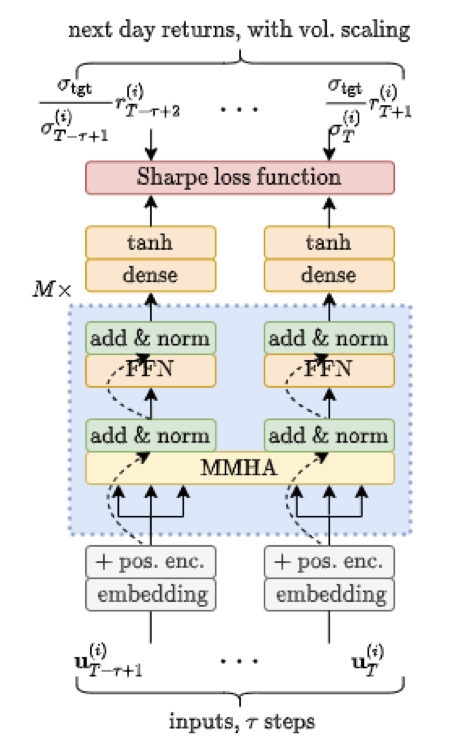

### Decoder
 
Let $X = \left( x_t^{(i)} \right)_{t=1}^{T}$ be the embedded and postitional encoded inputs of decoder, and $Z = \left( z_t^{(i)} \right)_{t=1}^{T}$ be the decoder output

$$
Z = (\text{Dec}_0^M \circ \cdots \circ \text{Dec}_0^1)(X)
$$
$$
\text{Dec}_0^i(X) = \phi(X' + \delta(\text{FFN}(X')))
$$
$$
X' = \phi(X + \delta(\text{MMHA}(X)))
$$


- $\text{MMHA}$ is the Masked Multihead Attention.
- $\delta(\cdot)$ is the dropout to prevent overfitting.
- $\phi(\cdot)$ is the layer normalization which normalises to 0 mean and 1 standard deviation.
- $M$ is the number of decoder layer.

### Output

The output of the model is the position $ {\bf I} = \left( I_t^{(i)} \right)_{t=1}^{T}$ of assets $i$, where $I_t^{(i)} \in [-1, 1]$:

$$
{\bf I} = \tanh(W_d Z + b_d)
$$

where

- $W_d$, $b_d$ is the learnable parameters of dense layer.

### Loss Function

The loss function used in this model is sharpe loss function, while we want to maximize the sharpe ratio, hence the sharpe loss function is defined as the negative of sharpe ratio.

$$
\mathcal{L}_{\text{sharpe}}(\Omega; \theta) = -\frac{\sqrt{252} \mathbb{E}_{\Omega}\left[R_t^{(i)}\right]}{\sqrt{\operatorname{Var}_{\Omega}\left[R_t^{(i)}\right]}}
$$

where

- $\theta$ is the model parameter.
- $\Omega$ is the set of all asset-time pairs in the minibatch.
  (i.e. $\Omega = \{ \frac{\sigma_{\text{tgt}}}{\sigma_{1}} r_1^{(1)} \cdots \frac{\sigma_{\text{tgt}}}{\sigma_{T}} r_T^{(1)} \cdots \frac{\sigma_{\text{tgt}}}{\sigma_{1}} r_1^{(N)} \cdots \frac{\sigma_{\text{tgt}}}{\sigma_{T}} r_T^{(N)} \}$)

- $R_t^{(i)}$ is the volitility scaled return captured by model of asset $i$ at time $t$.

  (i.e. $R_t^{(i)} = I_t^{(i)} \frac{\sigma_{\text{tgt}}}{\sigma_{t}^{(i)}} R_{t}^{(i)}$)

In [5]:
class Embedding(nn.Module):
    """
    Embedding
    input_size: dim of input_data
    embedding_size = embedding_size
    """
    def __init__(self, input_size, embedding_size):
        super(Embedding, self).__init__()
        self.embedding = nn.Linear(in_features = input_size, out_features = embedding_size, bias=False)
        
    def forward(self, input_seq):
        embedd = self.embedding(input_seq)
        return embedd
    
class Positional_Encodeing(nn.Module):
    """
    Positional_Encoding
    T: seq_length
    embedding_size = embedding_size
    """
    def __init__(self, embedding_size, T,batch_first = True):
        super(Positional_Encodeing, self).__init__()
        self.batch_first = batch_first
        self.embedding_size = embedding_size
        self.T = T
        
    def forward(self, embedd):
        pos_encoding = np.zeros((self.T, self.embedding_size))# (Sequence length, Dimensionality)
        # Compute the positional encoding values
        for pos in range(self.T):
            for i in range(0, self.embedding_size, 2):
                pos_encoding[pos, i] = np.sin(pos / (10000 ** ((2 * i) / self.embedding_size)))
                if i + 1 < embedd.size(1):
                    pos_encoding[pos, i + 1] = np.cos(pos / (10000 ** ((2 * (i + 1)) / self.embedding_size)))
        if self.batch_first and len(embedd.size())==3:
            decoder_input = embedd[:,] + torch.tensor(pos_encoding, dtype = torch.float)
        else:
            decoder_input = embedd + torch.tensor(pos_encoding, dtype = torch.float)
        return decoder_input
    
class Decoder(nn.Module):
    """
    Decoder
    embedding_size: embedding_size
    d_decoder: dim of feature size in decdoer
    num_heads: number of heads of multihead attention
    dropout: dropout value to prevant overfitting
    """
    def __init__(self, embedding_size, d_decoder, num_heads, dropout):
        super(Decoder, self).__init__()
        self.q = nn.Linear(in_features = embedding_size, out_features = d_decoder)
        self.k = nn.Linear(in_features = embedding_size, out_features = d_decoder)
        self.v = nn.Linear(in_features = embedding_size, out_features = d_decoder)
        self.MMHA = nn.MultiheadAttention(embed_dim=d_decoder, num_heads=num_heads,batch_first=True)
        self.ffn1 = nn.Linear(in_features = d_decoder, out_features = d_decoder)
        self.ffn2 = nn.Linear(in_features = d_decoder, out_features = d_decoder)
        self.layer_norm = nn.LayerNorm(d_decoder)
        self.dropout = nn.Dropout(dropout)
        self.Relu = nn.ReLU()
        
    def forward(self, decoder_input):
        # query, key, value construction
        q = self.q(decoder_input)
        k = self.k(decoder_input)
        v = self.v(decoder_input)
        # MMHA + add & norm
        attn_mask = torch.triu(torch.ones(decoder_input.size(1), decoder_input.size(1)) * float('-inf'), diagonal=1)
        e1_outputs, e1_weight = self.MMHA(q,k,v, attn_mask=attn_mask)
        e2 = self.layer_norm(self.dropout(e1_outputs) + decoder_input)
        
        # FFN + add & norm
        decoder_output = self.layer_norm(self.dropout(self.ffn2(self.Relu(self.ffn1(e2)))) + e2)
        return decoder_output
    
class D_Transformer(nn.Module):
    """
    D_Transformer
    M: number of dncoder layer
    embedding_size: embedding_size
    d_decoder: dim of feature size in decdoer
    num_heads: number of heads of multihead attention
    dropout: dropout value to prevant overfitting
    T: seq_length
    """
    def __init__(self, M, input_size, embedding_size, d_decoder, num_heads, dropout, T):
        super(D_Transformer, self).__init__()
        self.decoders = []
        for _ in range(M):
            self.decoders.append(Decoder(embedding_size, d_decoder, num_heads, dropout))
        self.embedding = Embedding(input_size, embedding_size)
        self.positional_encoding = Positional_Encodeing(embedding_size, T)
        self.dense = nn.Linear(in_features = d_decoder, out_features = 1)
        self.tanh = nn.Tanh() 
        
    def forward(self, input_seq):
        embedded_input = self.embedding(input_seq)
        decoder_result = self.positional_encoding(embedded_input)
        # Decoder stacked N times
        for decoder in self.decoders:
            decoder_result = decoder(decoder_result)
        # dense + tanh
        res = self.dense(decoder_result)
        pos = self.tanh(res).squeeze()
        return pos.squeeze()
    
class Sharpe_loss(nn.Module):
    def __init__(self):
        super(Sharpe_loss).__init__()
    def forward(self, model_output, target):
        # model output size(batch_size, N, T)
        # target size(batch_size, N, T)
        
        mu_R = torch.sum(model_output*target)/(target.numel())
        p = mu_R * torch.sqrt(torch.tensor(365.0))
        q = torch.sqrt(torch.var(model_output*target,dim=None))
    
        return -p/q
    
D_Transformer_model = D_Transformer(3, 2, 64, 64, 4, 0.1, 63)
criterion = SharpeLoss()
optimizer_D = torch.optim.Adam(D_Transformer_model.parameters(), 0.001)
epoch_scheduler_D = torch.optim.lr_scheduler.StepLR(optimizer_D, step_size=100, gamma=0.9)
D_Transformer_model_CPD = D_Transformer(3, 4, 64, 64, 4, 0.1, 63)
optimizer_D_CPD = torch.optim.Adam(D_Transformer_model_CPD.parameters(), 0.001)
epoch_scheduler_D_CPD = torch.optim.lr_scheduler.StepLR(optimizer_D_CPD, step_size=100, gamma=0.9)

In [6]:
def train_D_transformer(model, train_data, train_target_data, test_data, test_target_data, criterion, optimizer, epoch_scheduler, epoches = 500):
    
    hist_train_losses = []
    hist_test_losses = []
    
    for epoch in range(epoches):
        
        # Training set
        model.train()

        train_loss_list = []
        for batch_X, batch_Y in zip(train_data, train_target_data):
            batch_output = []
            for mini_batch in batch_X:
                mini_batch_output = model(mini_batch)
                batch_output.append(mini_batch_output)
            output = torch.stack(batch_output,dim=0)
            train_loss = criterion.forward(output, batch_Y)
            train_loss_list.append(train_loss.detach().numpy())
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()
        hist_train_losses.append(np.array(train_loss_list).mean())

        # Testing set
        model.eval()

        test_loss_list = []
        for batch_X, batch_Y in zip(test_data, test_target_data):
            batch_output = []
            for mini_batch in batch_X:
                mini_batch_output = model(mini_batch)
                batch_output.append(mini_batch_output)
            output = torch.stack(batch_output,dim=0)
            test_loss = criterion.forward(output, batch_Y)
            test_loss_list.append(test_loss.detach().numpy())
        hist_test_losses.append(np.array(test_loss_list).mean())
    
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epoches}], Train Sharpe Loss: {hist_train_losses[epoch]:.8f}, Test Sharpe Loss: {hist_test_losses[epoch]:.8f}')
            
        epoch_scheduler.step()
    
    plt.figure(figsize=(10, 6))
    plt.plot(hist_train_losses,label='Train Sharpe Loss')
    plt.plot(hist_test_losses,label='Test Sharpe Loss')
    plt.title('Sharpe Loss')
    plt.xlabel('Epoches')
    plt.ylabel('Sharpe Loss') 
    plt.legend()
    plt.show()

## 3. Temporal Fusion Transformer

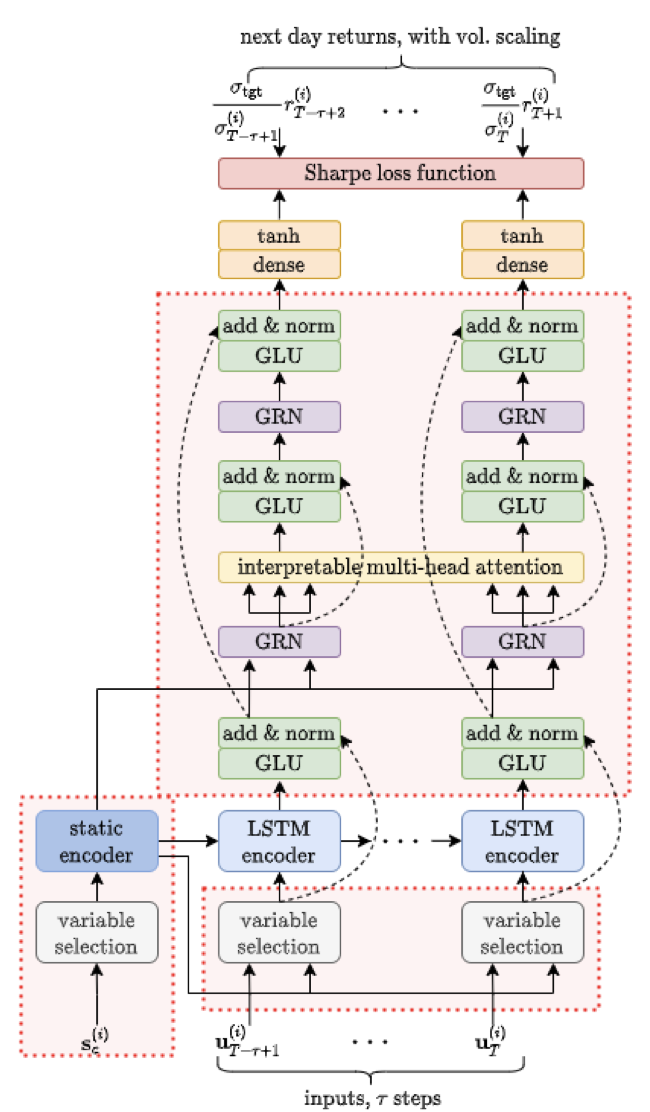

## The major constituents of TFT

## Gating mechanisms

### Architecture

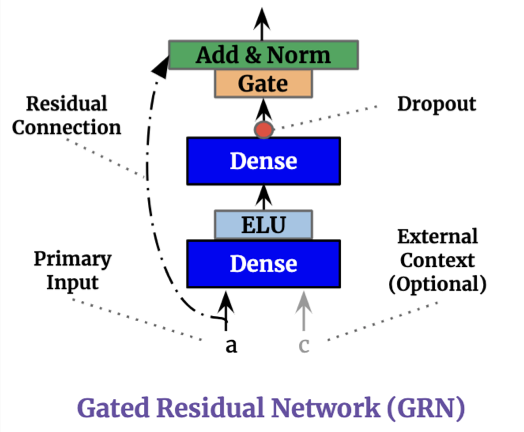

GRN can skip over any unused components of the architecture, providing adaptive depth and network complexity to accommodate a wide range of datasets and scenarios.

$$
\text{GRN}(a, c) = \text{LayerNorm} \left( \mathbf{W}_{6} a + \text{GLU}(\eta_1) \right)
$$

$$
\eta_1 = \mathbf{W}_{1} \eta_2 + \mathbf{b}_{1}
$$

$$
\eta_2 = \text{ELU} \left( \mathbf{W}_{2} a + \mathbf{W}_{3} c + \mathbf{b}_{2} \right)
$$

$$
\text{GLU}(\gamma) = \sigma \left( \mathbf{W}_{4} \gamma + \mathbf{b}_{4} \right) \odot \left( \mathbf{W}_{5} \gamma + \mathbf{b}_{5} \right)
$$

where

- $\mathbf{W}$ terms represent weight matrices.
- $\mathbf{b}$ terms represent bias term.
- $\odot$ Element-wise multiplication operation.
- $\sigma$ is the active function
- $\text{ELU}$ is the active function with $\alpha$ = 1

## Variable selection networks

### Architecture

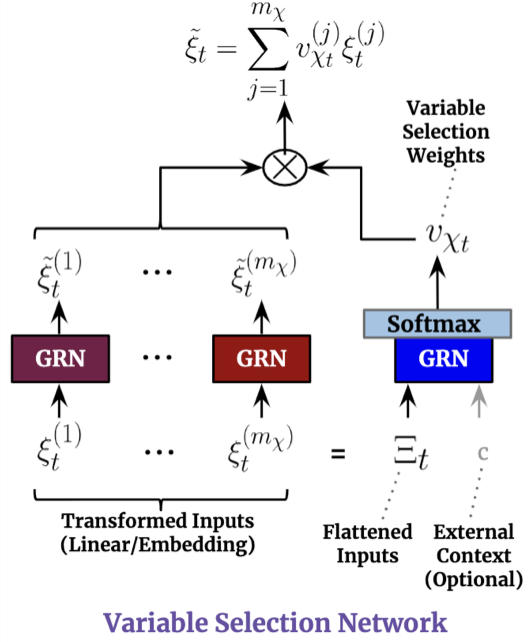

By using GRN, Variable selection network select relevant input variables at each time step.

$$
\Xi_t = \left[ \xi_t^{(1)T}, \ldots, \xi_t^{(m_\chi)T} \right]^T
$$

$$
v_{\chi t} = \text{Softmax} \left( \text{GRN}_{v_{\chi}} \left( \Xi_t, c_s \right) \right),
$$

$$
\tilde{\xi}_t^{(j)} = \text{GRN}_{\tilde{\xi}_{(j)}} \left( \xi_t^{(j)} \right),
$$

$$
\tilde{\xi}_t = \sum_{j=1}^{m_\chi} v_{\chi t}^{(j)} \tilde{\xi}_t^{(j)},
$$

where

- $\xi_t^{(i)T}$ is the $i$-th embedded input at time $t$.
- $\Xi_t$ is the flattened vector of all inputs at time $t$. 

## Static covariate encoders

### Motivation

Integrate static features into the network, through encoding of context vectors to condition temporal dynamics.

### Architecture

In the Temporal Fusion Transformer (TFT) model, the context vectors $\mathbf{c}_s$, $\mathbf{c}_c$, $\mathbf{c}_h$, and $\mathbf{c}_e$ are generated by the static covariate encoders. These context vectors play crucial roles in different parts of the model, helping it to better handle and utilize static features. Below is the process of generating these context vectors:

$$
\mathbf{c}_s = \text{GRN}_{c_s}(\zeta)
$$

$$
\mathbf{c}_c = \text{GRN}_{c_c}(\zeta)
$$

$$
\mathbf{c}_h = \text{GRN}_{c_h}(\zeta)
$$

$$
\mathbf{c}_e = \text{GRN}_{c_e}(\zeta)
$$

where 

- $\text{GRN}$ is a Gated Residual Network used to generate these context vector.
- $\mathbf{c}_s$ is the external input of variable selection model.
- $\mathbf{c}_c$ is the initial cell state of LSTM.
- $\mathbf{c}_h$ is the initial hidden state of LSTM.
- $\mathbf{c}_e$ is the exteral input of first GRN.

## Interpretable Multi-Head Attention

### Motivation

Learn both long- and short-term temporal relationships from both observed and known time-varying inputs. A sequence- to-sequence layer is employed for local processing, whereas long-term dependencies are captured using a novel interpretable multi-head attention block.

### Architecture

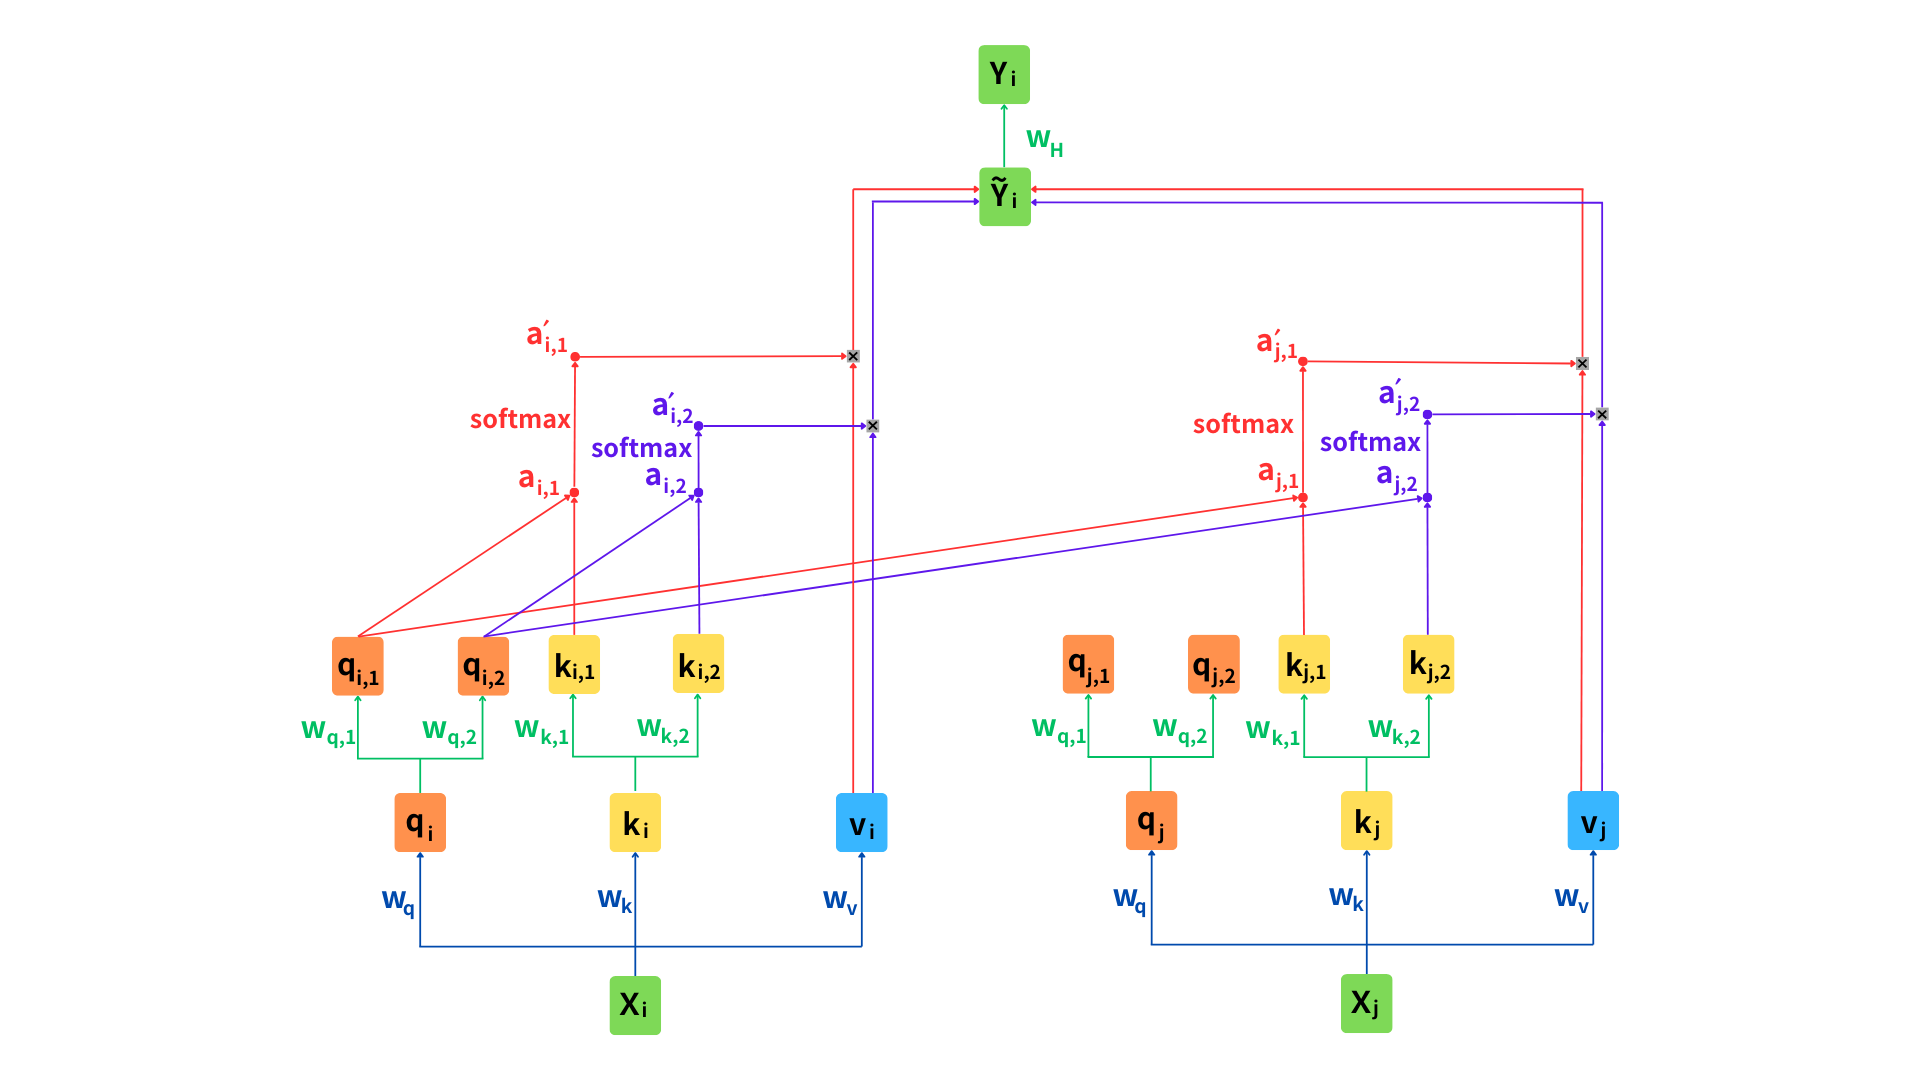

1. **Construction of Queries, Keys and Values**

    Using the weight matrices operates on input vectors to construct $n$ queries, keys and values.

    $$
    \begin{align*}
    {\bf q}_i &= W_q {\bf x}_i
    \\
    {\bf k}_i &= W_k {\bf x}_i
    \\
    {\bf v}_i &= W_v {\bf x}_i
    \end{align*}
    $$

2. **Construction of Subqueries and Subkeys**

    Using the weight matrices operates on queries, keys and values to construct $m$ Subqueries and Subkeys respectively.

    $$
    \begin{align*}
    {\bf q}_{ij} &= W^Q_j {\bf q}_i
    \\
    {\bf k}_{ij} &= W^K_j {\bf k}_i
    \end{align*}
    $$

3. **Attention**

    For each ${\bf q}_{ij}$ calculate the Attention with $\mathcal{D}_j = \lbrace({\bf k}_{1j},{\bf v}_{1}), \cdots, ({\bf k}_{nj},{\bf v}_{n})\rbrace$.

    $$
    \text{head}_{ij} = \text{Attention}({\bf q}_{ij}, \mathcal{D}_j) = \sum_{k=1}^{n}\text{Softmax}(\frac{{\bf q}_{ij} {\bf k}_{kj}^{T}}{\sqrt{d_j}}){\bf v}_{k}
    $$

4. **Summation of Heads**

    Sum the Attention of each heads, and multiply with a weight matrix, $\mathcal{D} = \lbrace({\bf k}_{1},{\bf v}_{1}), \cdots, ({\bf k}_{n},{\bf v}_{n})\rbrace$..

    $$
    \text{InterpretableMultiHead}({\bf q}_i, \mathcal{D}) = \frac{1}{H}\sum^{m}_{j=1}\text{head}_{ij}W_{H}
    $$

where:

- ${\bf x}_i$ are the  $i$-th input vector.
- ${\bf q}_i, {\bf k}_i, {\bf v}_i$ are query, key, value of ${\bf x}_i$ respectively.
- ${\bf q}_{ij}, {\bf k}_{ij}$ is the subquery of ${\bf q}_i$, subkey of ${\bf k}_i$ respectively.
- $W$ terms represent weight matrices (e.g., $W_q$, $W_k$, $W_v$) that are learned during training.
- $d_j$ is the dimension of ${\bf k}_{ij}$
- $H = nm$ 

In general Interpretable Multi-Head can be written as:

$$
\text{InterpretableMultiHead}(Q, K, V) = \tilde{H} W_H
$$

$$
\begin{align*}
\tilde{H} &= \tilde{A}(Q, K) V W_V
\\
&=\left\{ \frac{1}{H} \sum_{i=1}^{m} \text{Softmax} \left(\frac{(Q W_i^{Q}) (K W_i^{K})^{T}}{\sqrt{d_j}}\right) \right\} V W_V
\\
&=\frac{1}{H} \sum_{i=1}^{m} \text{Attention} \left( Q W_i^{Q}, K W_i^{K}, V W_V \right)
\end{align*}
$$



In [99]:
class GLU(nn.Module):
    """
    GLU
    input_dim: dim of input
    hidden_dim: hidden dim of model
    """
    def __init__(self, input_dim, output_dim):
        super(GLU, self).__init__()
        
        self.glu1 = nn.Linear(input_dim, output_dim)
        self.glu2 = nn.Linear(input_dim, output_dim)
        
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        """
        Arg:
            x (tensor): size(x.size(0), input_dim)
        Returns:
            (tensor): size(x.size(0), hidden_dim)
        """
        return self.sigmoid(self.glu1(x))*self.glu2(x)

class GRN(nn.Module):
    """
    GRN
    input_dim_a: dim of input a
    input_dim_c: dim of input c(optional)
    hidden_dim: hidden dim of model
    dropout: dropout rate
    additional: Ture --> input c required, False --> input_c ignored
    """
    def __init__(self, input_dim_a, input_dim_c, hidden_dim, output_dim, dropout, additional = False):
        super(GRN, self).__init__()
        
        self.input_dim_a = input_dim_a
        self.input_dim_c = input_dim_c
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.additional = additional
        
        self.trans = nn.Linear(input_dim_a, output_dim)
        self.dense1 = nn.Linear(input_dim_a, hidden_dim)
        self.dense2 = nn.Linear(input_dim_c, hidden_dim)
        self.dense3 = nn.Linear(hidden_dim, hidden_dim)
        self.glu = GLU(hidden_dim, output_dim)

        self.norm = nn.LayerNorm(output_dim)
        
        self.elu = nn.ELU()
        self.sigmoid = nn.Sigmoid()
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, a, c):
        """
        Arg:
            a (tensor): size(a.size(0), dim_a)
            c (tensor): size(a.size(0), dim_c)
        Returns:
            (tensor): size(a.size(0), output_dim)
        """
        
        if self.additional == False:
            c = torch.zeros((a.size(0), self.input_dim_c))
            
        eta1 = self.elu(self.dense1(a)+ self.dense2(c))
        eta2 = self.dense3(eta1)
        eta2 = self.dropout(eta2)
        eta3 = self.glu(eta2)
        if self.input_dim_a != self.output_dim:
            return self.norm(self.trans(a) + eta3)
        else:
            return self.norm(a + eta3)


class VSN(nn.Module):
    """
    VSN
    N: # of assets
    input_dim: dim of input a
    input_dim_c: dim of input c(optional)
    hidden_dim: hidden dim of model
    dropout: dropout rate
    additional: Ture --> input c required, False --> input_c ignored
    """
    def __init__(self, N, input_dim, input_dim_c, hidden_dim, output_dim, dropout, additional = True):
        super(VSN, self).__init__()
        
        self.N = N
        self.input_dim = input_dim
        self.input_dim_c = input_dim_c
        self.hidden_dim = hidden_dim
        self.additional = additional
        self.grn_list = []
        
        for _ in range(N):
            self.grn_list.append(GRN(input_dim, 1, hidden_dim, output_dim, dropout, additional = False))
            
        if additional == True:
            self.grnfi = GRN(input_dim, input_dim_c, hidden_dim, 1, dropout, additional = True)
        else:
            self.grnfi = GRN(input_dim, 1, hidden_dim, 1, dropout, additional = False)
            
    def forward(self, input, c):
        """
        Arg:
            input (tensor): size(input.size(0), dim_a)
            c (tensor): size(input.size(0), dim_c)
        Returns:
            (tensor): size(input.size(0), output_dim)
        """
        tilde = []
        k=0
        for i in range(self.N):
            tilde.append(self.grn_list[i](input[i].unsqueeze(0), k))
        tilde = torch.stack(tilde, dim=0).squeeze(1)
        v1 = self.grnfi(input, c)
        weight = F.softmax(v1, dim=0)
        output = torch.sum(tilde*weight, dim=0).unsqueeze(0)
        
        return output
    
class Static_Encoder(nn.Module):
    """
    Static_Encoder
    input_dim_a: dim of input a
    hidden_dim: hidden dim of model
    dropout: dropout rate
    """
    def __init__(self, input_dim, hidden_dim, output_dim, dropout):
        super(Static_Encoder, self).__init__()
    
        self.grn_s = GRN(input_dim, 1, hidden_dim, output_dim, dropout, additional = False)
        self.grn_c = GRN(input_dim, 1, hidden_dim, output_dim, dropout, additional = False)
        self.grn_h = GRN(input_dim, 1, hidden_dim, output_dim, dropout, additional = False)
        self.grn_e = GRN(input_dim, 1, hidden_dim, output_dim, dropout, additional = False)
        
    def forward(self, x):
        """
        Args:
            x (tensor): size(x.size(0), input_dim)
        Returns:
            Cs (tensor): size(N, hidden_dim)
            Cc (tensor): size(N, hidden_dim)
            Ch (tensor): size(N, hidden_dim)
            Ce (tensor): size(N, hidden_dim)
        """
        c = 0
        Cs = self.grn_s(x, c)
        Cc = self.grn_c(x, c)
        Ch = self.grn_h(x, c)
        Ce = self.grn_e(x, c)
        
        return Cs, Cc, Ch, Ce

class IMHA(nn.Module):
    """
    IMHA
    input_dim: dim of input
    hidden_dim: hidden dim of model
    output_dim: dim of output
    num_head: # of head
    """
    def __init__(self, input_dim, hidden_dim, output_dim, num_head):
        super(IMHA, self).__init__()
        self.Wq = nn.Linear(input_dim, hidden_dim)
        self.Wk = nn.Linear(input_dim, hidden_dim)
        self.Wv = nn.Linear(input_dim, hidden_dim)
        self.Wqh_list = []
        self.Wkh_list = []
        self.num_head = num_head
        self.hidden_dim = hidden_dim
        self.head_dim = hidden_dim//num_head
        for _ in range(num_head):
            self.Wqh_list.append(nn.Linear(hidden_dim, self.head_dim))
            self.Wkh_list.append(nn.Linear(hidden_dim, self.head_dim))
        self.WH = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        """
        Args:
            x (tensor): size(x.size(0), input_dim)
        Returns:
            result (tensor): size(x.size(0), output_dim)
        """
        Q = self.Wq(x)
        K = self.Wk(x)
        V = self.Wv(x)
        sum = torch.zeros((x.size(0), self.hidden_dim))
        for i in range(self.num_head):
            q = self.Wqh_list[i](Q)
            k = self.Wkh_list[i](K).T
            sum += F.softmax((q@k)/self.head_dim, dim=1)@V
        sum = sum/(x.size(0)*self.num_head)
        result = self.WH(sum)
        return result
    
class TFT(nn.Module):
    """
    TFT
    N: # of assets
    T: # of days
    input_dim: dim of input
    hidden_dim: hidden dim of model
    num_head: # of head
    """
    def __init__(self, N, T, input_dim, hidden_dim, num_head, dropout):
        super(TFT, self).__init__()
        
        self.T = T
        self.embedding = nn.Embedding(num_embeddings=N, embedding_dim=hidden_dim)
        self.VSN_ex = VSN(N=N, input_dim=hidden_dim, input_dim_c=1, hidden_dim=hidden_dim, output_dim=hidden_dim, dropout=dropout, additional = False)
        self.static_encoder = Static_Encoder(input_dim=hidden_dim, hidden_dim=hidden_dim, output_dim=hidden_dim, dropout=dropout)
        
        self.VSN_list = []
        for _ in range(T):
            self.VSN_list.append(VSN(N=N, input_dim=input_dim, input_dim_c=hidden_dim, hidden_dim=hidden_dim, output_dim=hidden_dim, dropout=dropout, additional = True))
        self.lstm = nn.LSTM(input_size = hidden_dim, hidden_size = hidden_dim, num_layers = 1)
        self.imha = IMHA(input_dim=hidden_dim, hidden_dim=hidden_dim, output_dim=hidden_dim, num_head=num_head)
        self.glu1 = GLU(input_dim=hidden_dim, output_dim=hidden_dim)
        self.glu2 = GLU(input_dim=hidden_dim, output_dim=hidden_dim)
        self.glu3 = GLU(input_dim=hidden_dim, output_dim=hidden_dim)
        self.norm = nn.LayerNorm(hidden_dim)
        self.grn1 = GRN(input_dim_a=hidden_dim, input_dim_c=hidden_dim, hidden_dim=hidden_dim, output_dim=hidden_dim, dropout=dropout, additional = True)
        self.grn2 = GRN(input_dim_a=hidden_dim, input_dim_c=1, hidden_dim=hidden_dim, output_dim=hidden_dim, dropout=dropout, additional = False)
        self.dense = nn.Linear(hidden_dim, N)
        self.tanh = nn.Tanh()
        
    def forward(self, input, Sc):
        """
        Args:
            input (tensor): size(N, T, 2)
            Sc (tensor): size(N, 1)
        Returns:
            model_output: size(N, T)
        """
        # static encoder
        c=0
        Sc1 = self.embedding(Sc)
        Sc2 = self.VSN_ex(Sc1, c)
        Cs, Cc, Ch, Ce = self.static_encoder(Sc2)
        
        # VSN
        input_vsn = input.transpose(0, 1)
        output_vsn = []
        for i in range(self.T):
            output_vsn.append(self.VSN_list[i](input_vsn[i], Cs))
        output_vsn = torch.stack(output_vsn, dim=0).squeeze(1)
        # LSTM
        lstm_output, _ = self.lstm(output_vsn, (Ch, Cc))
        # 1st GLU
        glu1_1 = self.glu1(lstm_output) + output_vsn
        glu1_2 = self.norm(glu1_1)
        
        # 1st GRN
        grn1 = self.grn1(glu1_2, Ce)
        
        # IMHA
        imha_output = self.imha(grn1)
        
        # 2nd GLU
        glu2_1 = self.glu2(imha_output) + grn1
        glu2_2 = self.norm(glu2_1)
        
        # 2nd GRN
        grn2 = self.grn2(glu2_2, c)
        
        # 3rd GLU
        glu3_1 = self.glu3(grn2) + glu1_2
        glu3_2 = self.norm(glu3_1)
        
        # dense & tanh
        dense_output = self.dense(glu3_2)
        model_output = self.tanh(dense_output)
        
        return model_output.T
    
class Sharpe_loss(nn.Module):
    def __init__(self):
        super(Sharpe_loss).__init__()
    def forward(self, model_output, target):
        # model output size(batch_size, N, T)
        # target size(batch_size, N, T)
        
        mu_R = torch.sum(model_output*target)/(target.numel())
        p = mu_R * torch.sqrt(torch.tensor(365.0))
        q = torch.sqrt(torch.var(model_output*target,dim=None))
    
        return -p/q
    
TFT_model = TFT(N=10, T=63, input_dim=2, hidden_dim=64, num_head=4, dropout=0.1)
criterion = SharpeLoss()
optimizer_TFT = torch.optim.Adam(TFT_model.parameters(), 0.001)
epoch_scheduler_TFT = torch.optim.lr_scheduler.StepLR(optimizer_TFT, step_size=100, gamma=0.9)

In [8]:
def train_TFT(model, train_data, train_target_data, test_data, test_target_data, criterion, optimizer, epoch_scheduler, epoches = 500):
    
    Sc = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    
    hist_train_losses = []
    hist_test_losses = []
    
    for epoch in range(epoches):
        
        # Training set
        model.train()

        train_loss_list = []
        for batch_X, batch_Y in zip(train_data, train_target_data):
            batch_output = []
            for mini_batch in batch_X:
                mini_batch_output = model(mini_batch, Sc)
                batch_output.append(mini_batch_output)
            output = torch.stack(batch_output,dim=0)
            train_loss = criterion.forward(output, batch_Y)
            train_loss_list.append(train_loss.detach().numpy())
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()
        hist_train_losses.append(np.array(train_loss_list).mean())

        # Testing set
        model.eval()

        test_loss_list = []
        for batch_X, batch_Y in zip(test_data, test_target_data):
            batch_output = []
            for mini_batch in batch_X:
                mini_batch_output = model(mini_batch, Sc)
                batch_output.append(mini_batch_output)
            output = torch.stack(batch_output,dim=0)
            test_loss = criterion.forward(output, batch_Y)
            test_loss_list.append(test_loss.detach().numpy())
        hist_test_losses.append(np.array(test_loss_list).mean())
    
        if (epoch+1) % 1 == 0:
            print(f'Epoch [{epoch+1}/{epoches}], Train Sharpe Loss: {hist_train_losses[epoch]:.8f}, Test Sharpe Loss: {hist_test_losses[epoch]:.8f}')
            
        epoch_scheduler.step()
    
    plt.figure(figsize=(10, 6))
    plt.plot(hist_train_losses,label='Train Sharpe Loss')
    plt.plot(hist_test_losses,label='Test Sharpe Loss')
    plt.title('Sharpe Loss')
    plt.xlabel('Epoches')
    plt.ylabel('Sharpe Loss') 
    plt.legend()
    plt.show()

In [9]:
a = TFT(N = 10, T = 5, input_dim = 2, hidden_dim = 4, num_head = 2, dropout = 0.1)
b = torch.ones((10,5,2))
c = torch.ones((10)).long()
print(a(b, c))

tensor([[ 0.6749,  0.6482,  0.7366,  0.4808,  0.1554],
        [-0.4778, -0.0231,  0.0346, -0.2566, -0.6120],
        [ 0.1201, -0.4317, -0.4194, -0.3081,  0.1320],
        [ 0.2007,  0.5010,  0.4532,  0.4982,  0.3754],
        [-0.1442,  0.0864,  0.0498,  0.0732,  0.0061],
        [ 0.4802,  0.2975,  0.5073, -0.0170, -0.4218],
        [ 0.3672, -0.4366, -0.3647, -0.3398,  0.1365],
        [-0.6026,  0.1706, -0.0084,  0.1969, -0.0843],
        [ 0.7444,  0.8007,  0.7538,  0.8508,  0.8429],
        [-0.5237, -0.6411, -0.5562, -0.7287, -0.7310]],
       grad_fn=<PermuteBackward0>)


## Data Preparation

In [10]:
api_key = "iT7wFP3C0f4lIbAQFd"
api_secret = "B5dJcWVZqDBOwvyeQMk6h9DCvVSDvVPeBkJL"
session = HTTP(api_key=api_key, api_secret=api_secret, testnet=False)

In [11]:
def get_last_timestamp(df):
    
    return int(df.timestamp[-1:].values[0])

def format_data(response):
    
    data = pd.DataFrame(response, columns =['timestamp', 'open', 'high', 'low', 'close', 'volume', 'turnover'])
    f = lambda x: dt.datetime.utcfromtimestamp(int(x)/1000)
    data.index = data.timestamp.apply(f)
    return data[::-1].apply(pd.to_numeric)

def download_as_pd(symbol, interval, start, end):
    df = pd.DataFrame()
    while True:
        response = session.get_kline(category='linear', 
                                     symbol=symbol, 
                                     start=start,
                                     interval=interval,
                                     timeout=30).get('result').get('list')
        
        latest = format_data(response)
        start = get_last_timestamp(latest)
        time.sleep(0.1)
        df = pd.concat([df, latest])
        if start > end: break
    df.drop_duplicates(subset=['timestamp'], keep='last', inplace=True)
    return df

def normalization(data):
    """_summary_

    Args:
        data (pd.Series)

    Returns:
        _type_: pd.Series
    """
    mean = np.mean(data)
    std = np.std(data)
    batch_normalized_data = (data-mean)/std
    return batch_normalized_data

def EMA_calculate(returns_df, span):
    ema = returns_df.copy()
    ema.iloc[:span] = returns_df.iloc[:span].mean()
    EMA = ema.iloc[span-1:].ewm(alpha=2/(1+span), adjust=False).mean()
    return EMA

def EWMSD_calculate(returns_df, span):
    EMA = EMA_calculate(returns_df, span)
    variance = (returns_df.iloc[span-1:]-EMA)**2
    EWMV = variance.ewm(alpha=2/(1+span), adjust=False).mean()
    EWMSD = np.sqrt(EWMV)
    return EWMSD

def position_sizing(x):
    return x*np.exp(-(x**2)/4)/0.89

def element_concat(list1, list2):
    """_summary_

    Args:
        list1 (pd.Series)
        list2 (pd.Series)

    Returns:
        _type_: pd.Series
    """
    
    if list1.shape[0] <= list2.shape[0]:
        list1,list2 = list2,list1
    res_list = pd.Series([np.array(pair) for pair in zip(list1[list2.index], list2)], index = list2.index)
    return res_list

def compare_cumulative_returns(cumulative_returns_dic):
    plt.figure(figsize=(15, 8))
    for crypto, cumulative_returns in cumulative_returns_dic.items():
        plt.plot(cumulative_returns+1, label=crypto)

    plt.title("Cumulative Return")
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()

In [12]:
span = 60
S = 8
L = 24
tgt_volitility = 0.15
T = 63
batch_size = 64
LBW = 10

In [83]:
class Datas():
    def __init__(self, crypto, S, L, span, tgt_volitility,CPD = False):
        self.crypto = crypto
        self.tgt_volitility = tgt_volitility
        df = download_as_pd(crypto, "D", int(dt.datetime(2022, 1, 1).timestamp() * 1000), int(dt.datetime(2024, 6, 15).timestamp() * 1000))
        self.closed_price = df["close"]
        self.returns = self.closed_price.pct_change().dropna()
        self.cumulative_returns = (1 + self.returns).cumprod() - 1
        
        # price based
        self.EMA_S_closed_price = EMA_calculate(self.closed_price, S)
        self.EMA_L_closed_price = EMA_calculate(self.closed_price, L)
        self.MACD_closed_price = self.EMA_S_closed_price[L-S:] - self.EMA_L_closed_price
        self.normalized_MACD_closed_price = normalization(self.MACD_closed_price)
        self.EWMSD_closed_price = EWMSD_calculate(self.closed_price, span)
        
        # return based
        self.EMA_S_returns = EMA_calculate(self.returns, S)
        self.EMA_L_returns = EMA_calculate(self.returns, L)
        self.MACD_returns = self.EMA_S_returns[L-S:] - self.EMA_L_returns
        self.EWMSD_return = EWMSD_calculate(self.returns, span)
        
        self.U = element_concat(self.returns[self.EWMSD_return.index]/self.EWMSD_return, self.MACD_returns)[:-1]
        self.target = self.tgt_volitility*self.returns[self.EWMSD_return.index[1:]]/self.EWMSD_return.values[:-1]
        if CPD:
            df_CPD = pd.read_csv(f'C:\\Users\\林元鴻\\test\\python\\financial_mathematics\\{crypto}.csv')
            df_CPD.index = df_CPD['timestamp']
            self.U_CPD = df_CPD["U"][-len(self.U)-1:-1]
            self.U_CPD = self.str2np(self.U_CPD)
    def str2np(self,series):
        for i in range(len(series)):
            s = series[i][1:-1]
            L = []
            k = 1 if s[0] == ' ' else 0
            for j in range(len(s)-1):
                if (not s[j].isdigit()) and s[j] not in '-+e.' and j>1 and s[j-1] != ' ':
                    # print(s[k:j])
                    num = s[k:j] if s[k:j][-1]!='n' else 0
                    L.append(float(num))
                    if s[j+1]==' ':
                        k=j+2
                    else:
                        k=j+1
            if len(L) != 4:
                L.append(float(s[k:-1]))
            # print(L)
            L = np.array(L)
            series[i] = L
        return series
    def show_basic(self):
        plt.figure(figsize=(16, 9))
        plt.plot(self.closed_price.index, self.closed_price, label="Closed Price") 
        plt.plot(self.EMA_S_closed_price, label=f"EMA{S}")
        plt.plot(self.EMA_L_closed_price, label=f"EMA{L}")
        plt.plot(self.EWMSD_closed_price, label=f"EWMSD{span}")
        colors = ['green' if x > 0 else 'red' for x in self.normalized_MACD_closed_price]
        plt.bar(self.MACD_closed_price.index, self.MACD_closed_price, label=f"MACD({S},{L})", color=colors, width=0.8)
        plt.title(f"{self.crypto} Closed Prices")
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend()
        plt.show()
    
    def baz_strategy(self):
        std_pw = self.closed_price.rolling(window=30).std().dropna()
        x = self.MACD_closed_price[30-L:]/std_pw
        std_sw = x.rolling(window=60).std().dropna()
        y = x[60:]/std_sw
        Baz_position = y.apply(position_sizing)
        
        return Baz_position
            

In [84]:
cryptos_list = ["BTCUSDT", "ETHUSDT", "BNBUSDT", "SOLUSDT", "XRPUSDT", "DOGEUSDT", "ADAUSDT", "SHIB1000USDT", "AVAXUSDT", "TRXUSDT"]
data_dic = {}
for crypto in cryptos_list:
    data_dic[crypto] = Datas(crypto, S, L, span, tgt_volitility,CPD=True)

C:\Users\林元鴻\AppData\Local\Temp\ipykernel_8544\1919460790.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s = series[i][1:-1]
C:\Users\林元鴻\AppData\Local\Temp\ipykernel_8544\1919460790.py:48: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  series[i] = L
C:\Users\林元鴻\AppData\Local\Temp\ipykernel_8544\1919460790.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s = series[i][1:-1]
C:\Users\林元鴻\AppData\Local\Temp\ipykernel_85

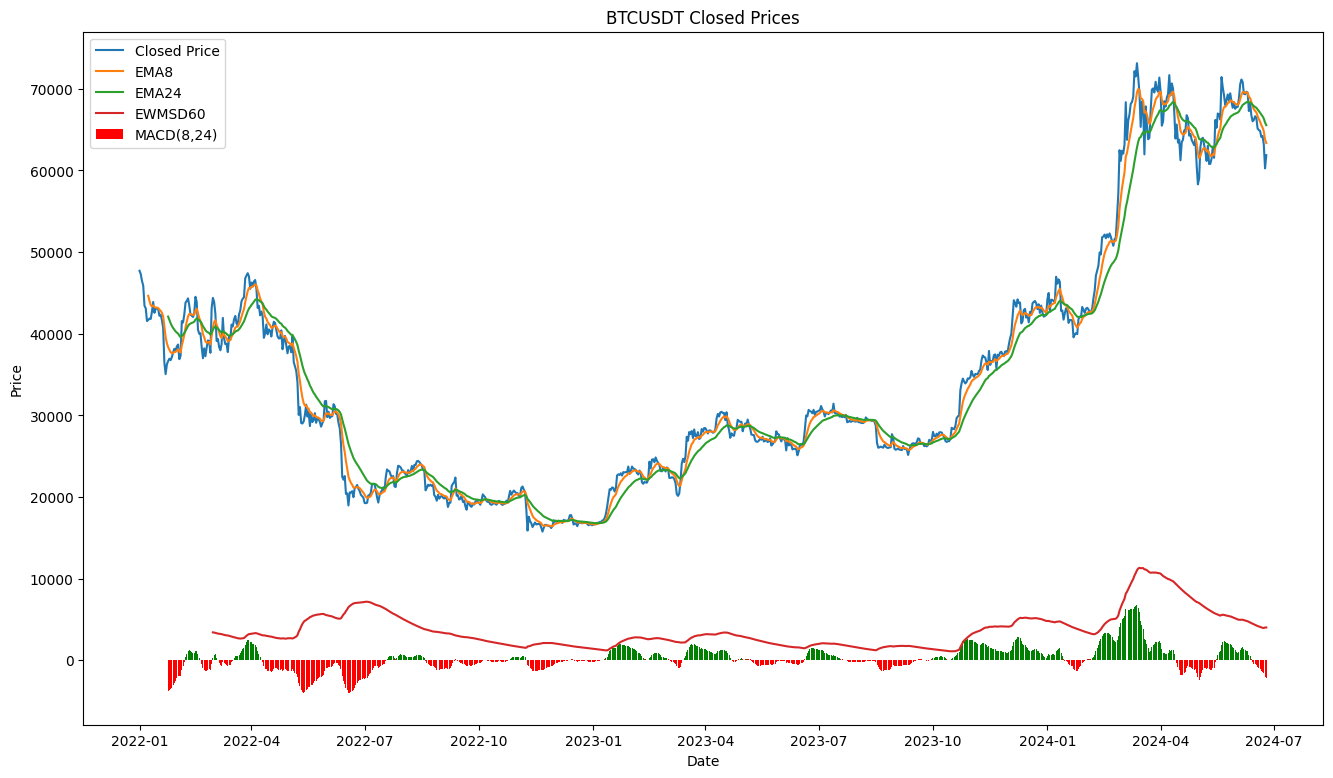

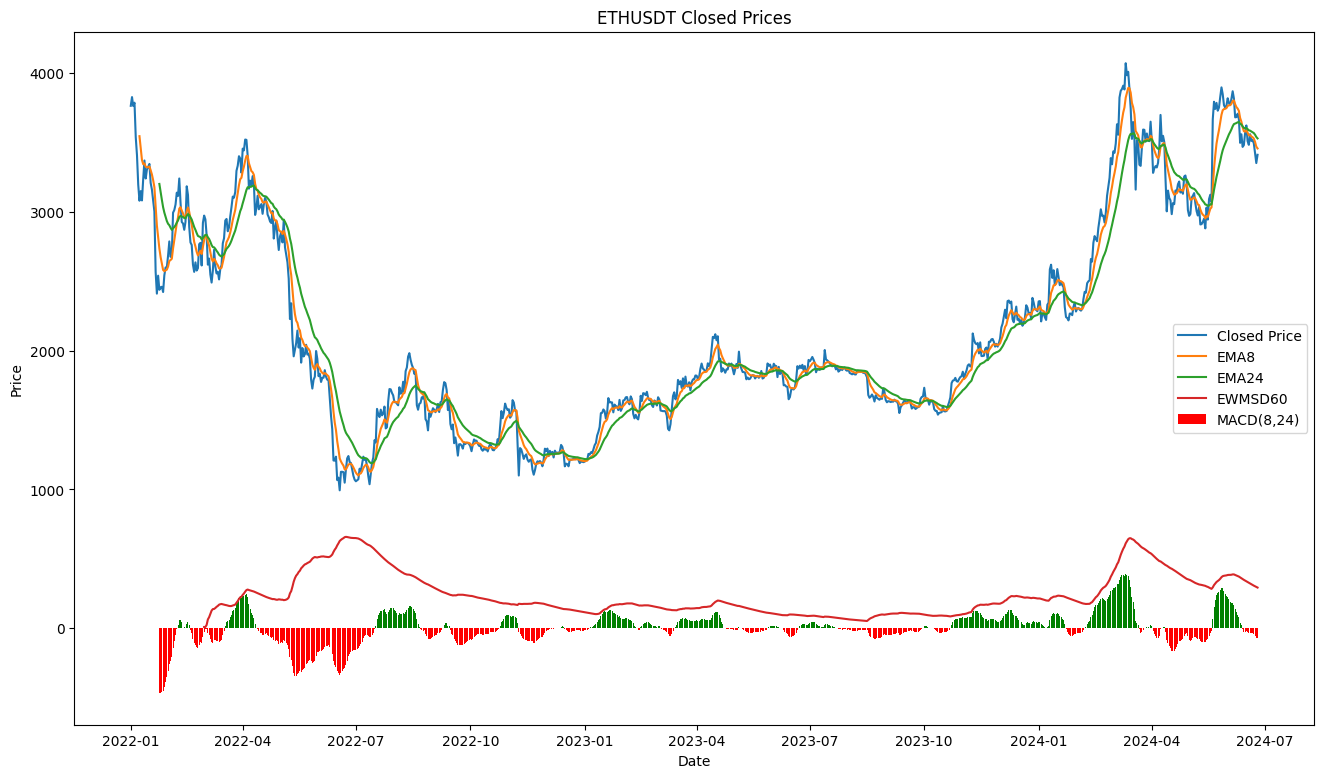

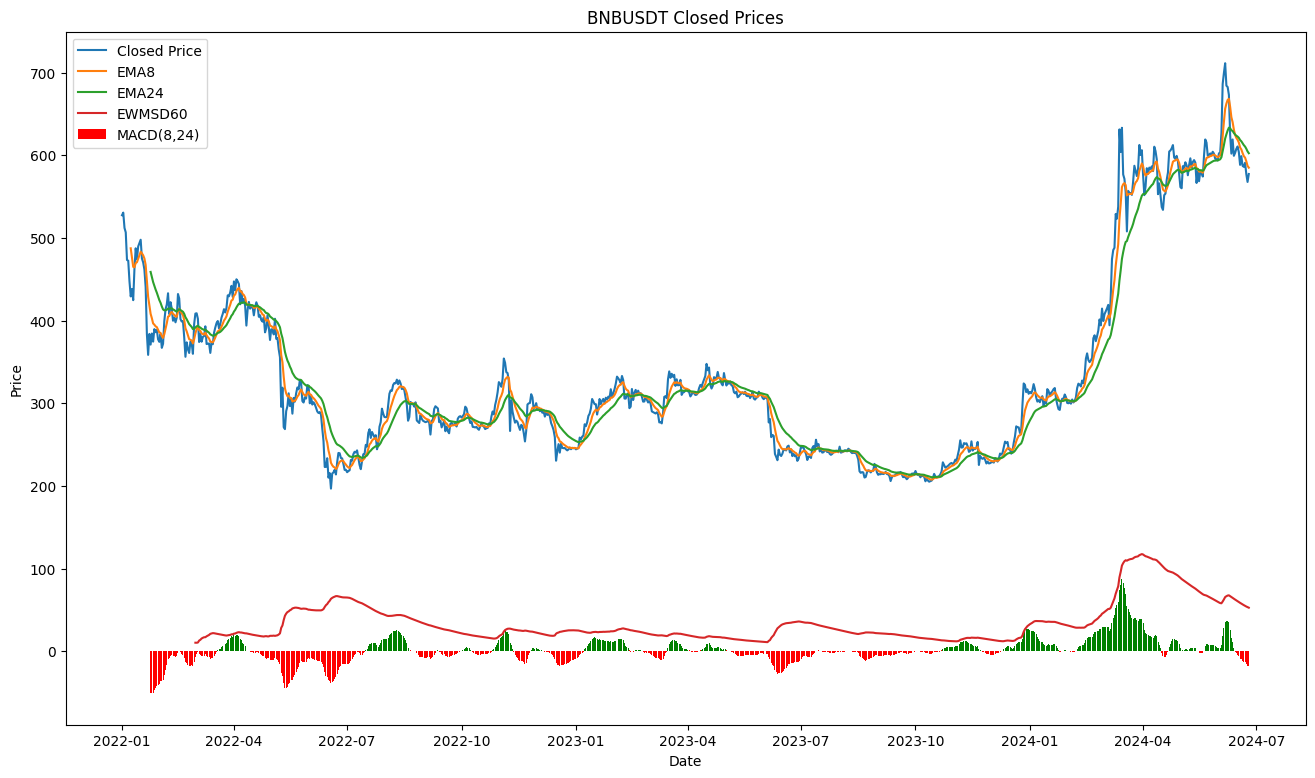

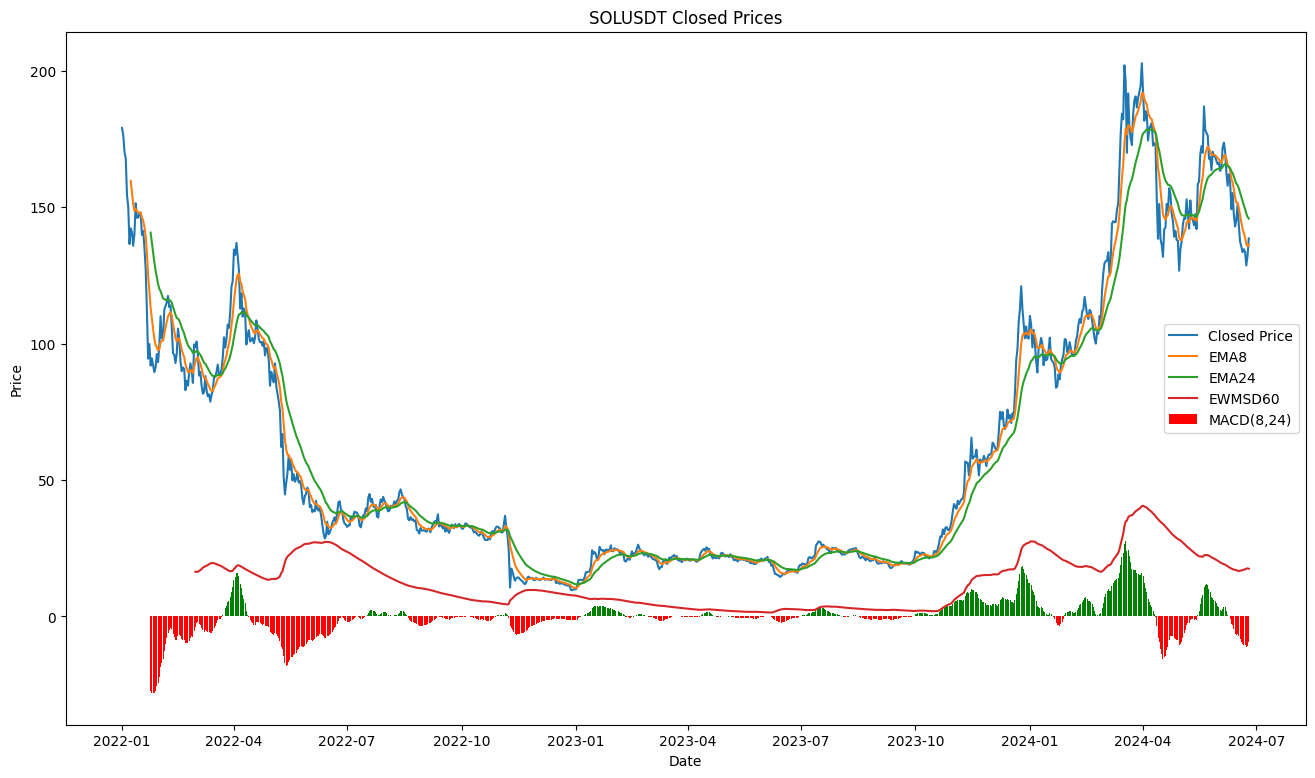

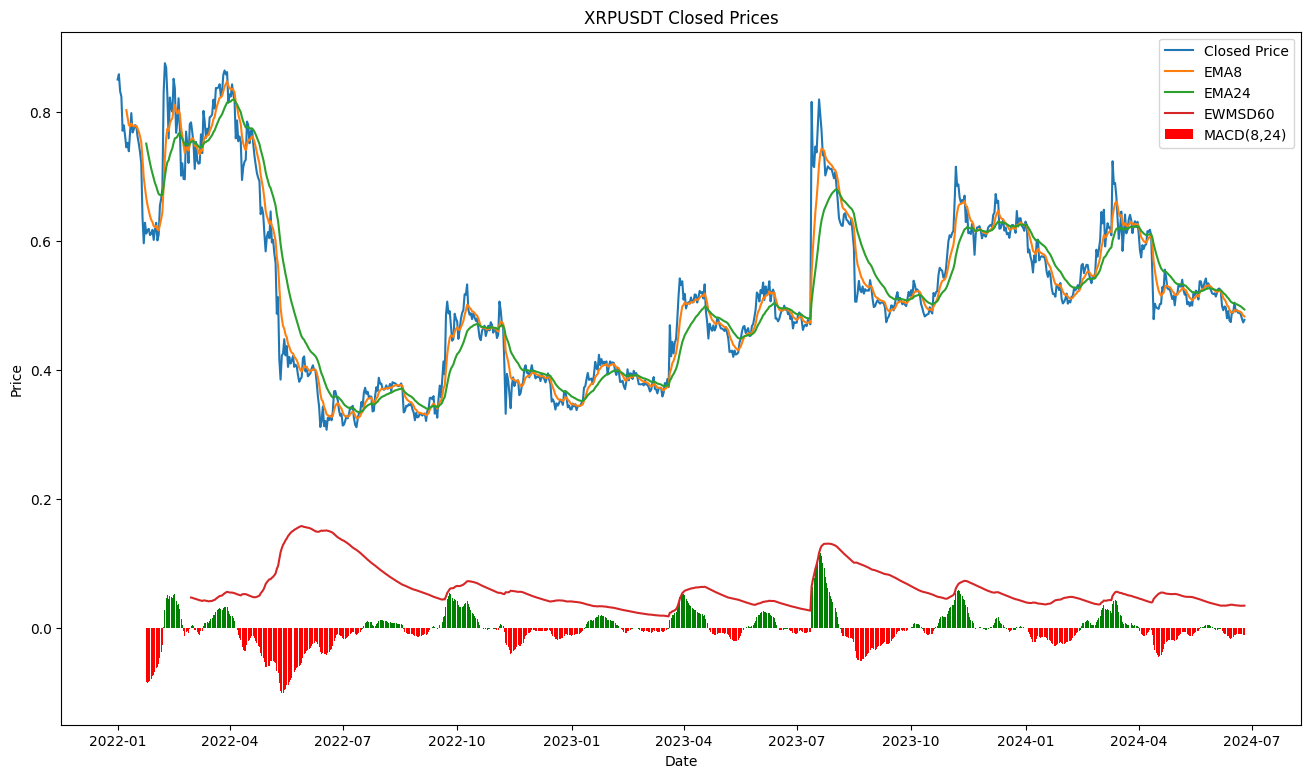

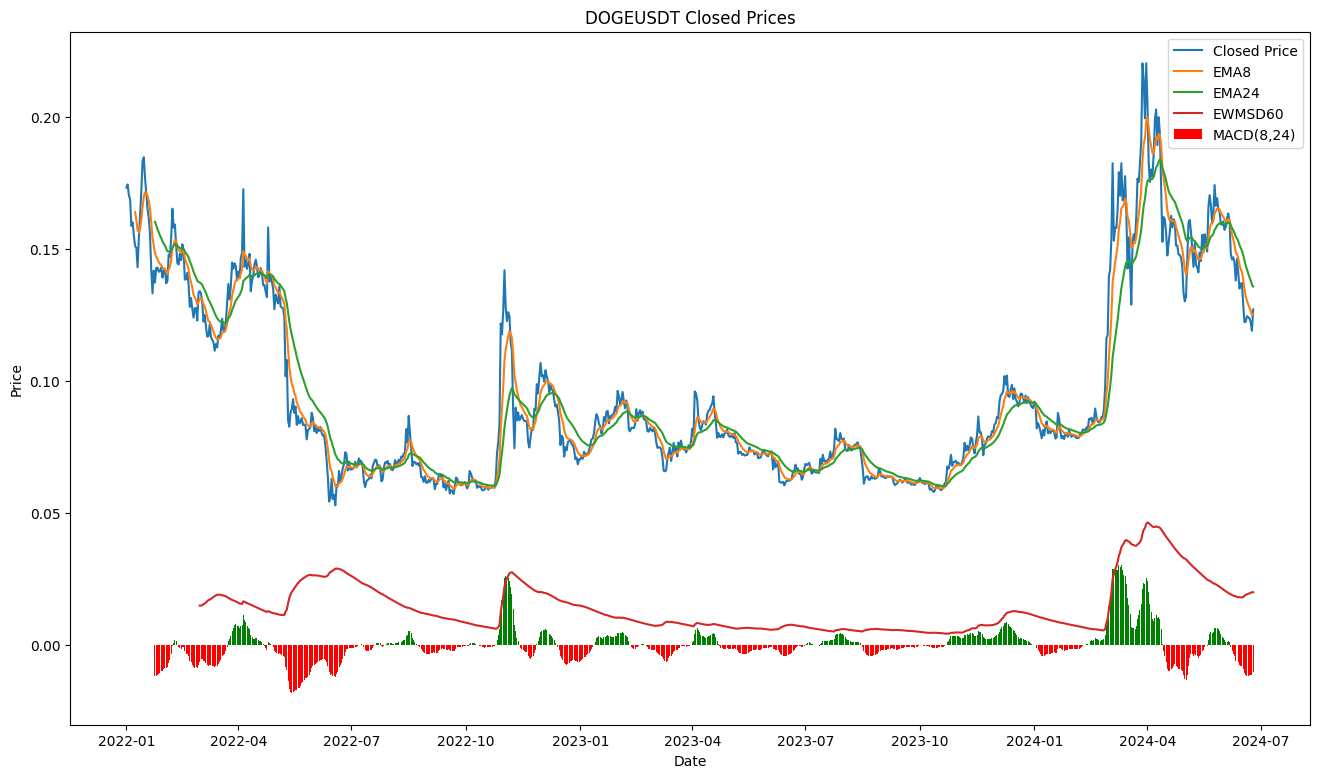

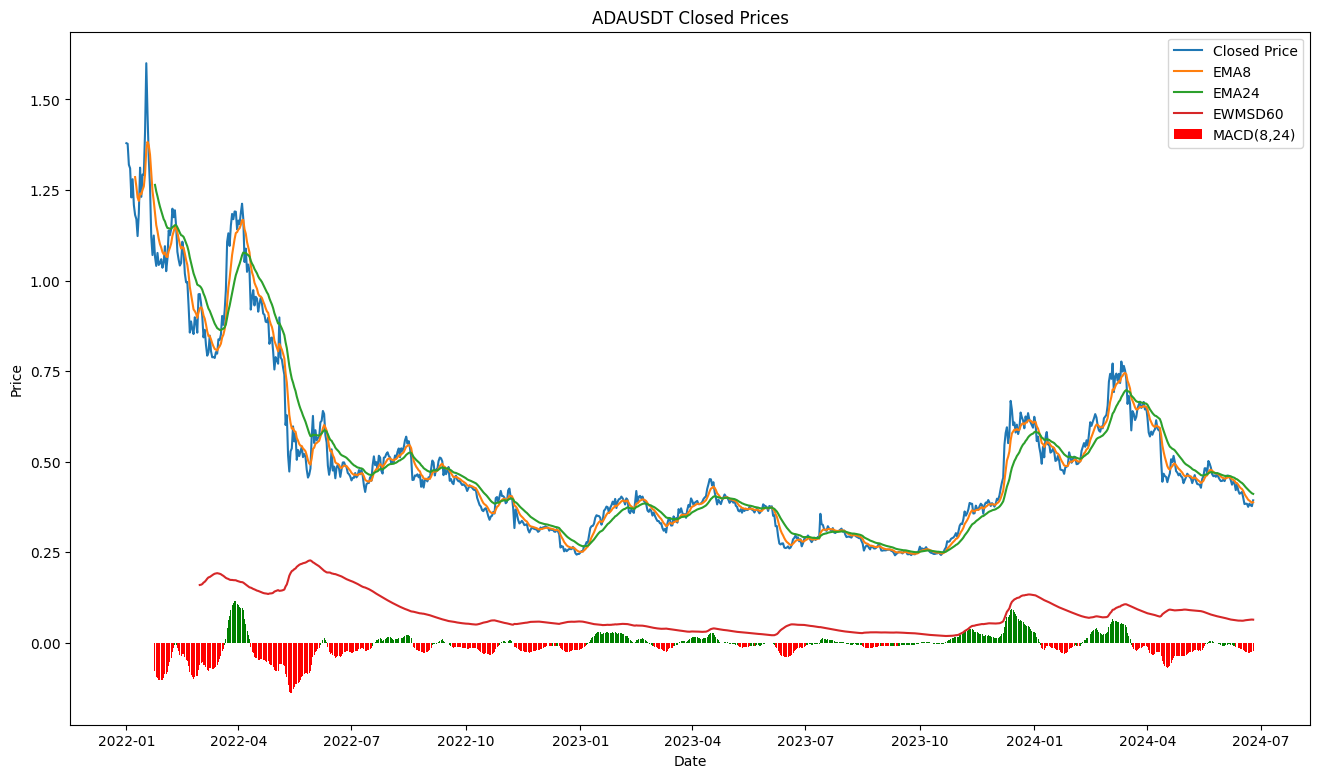

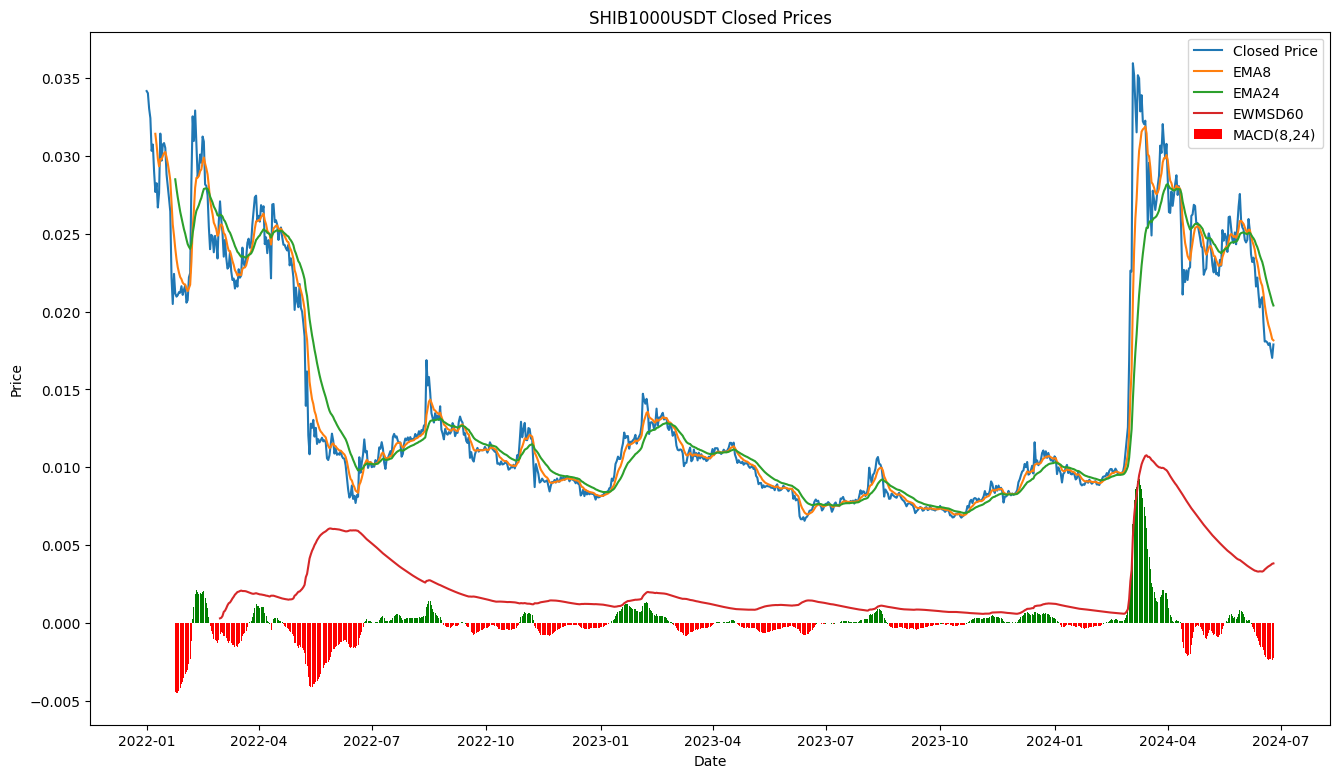

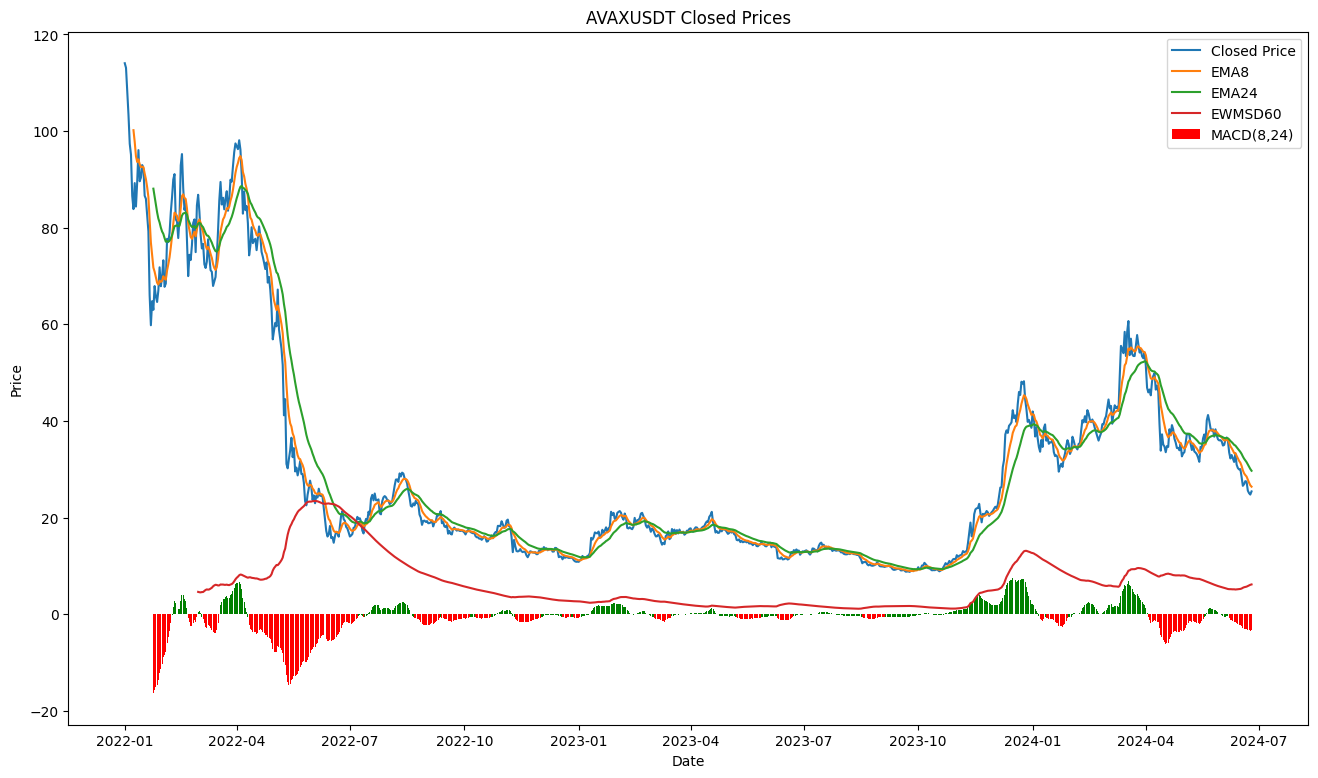

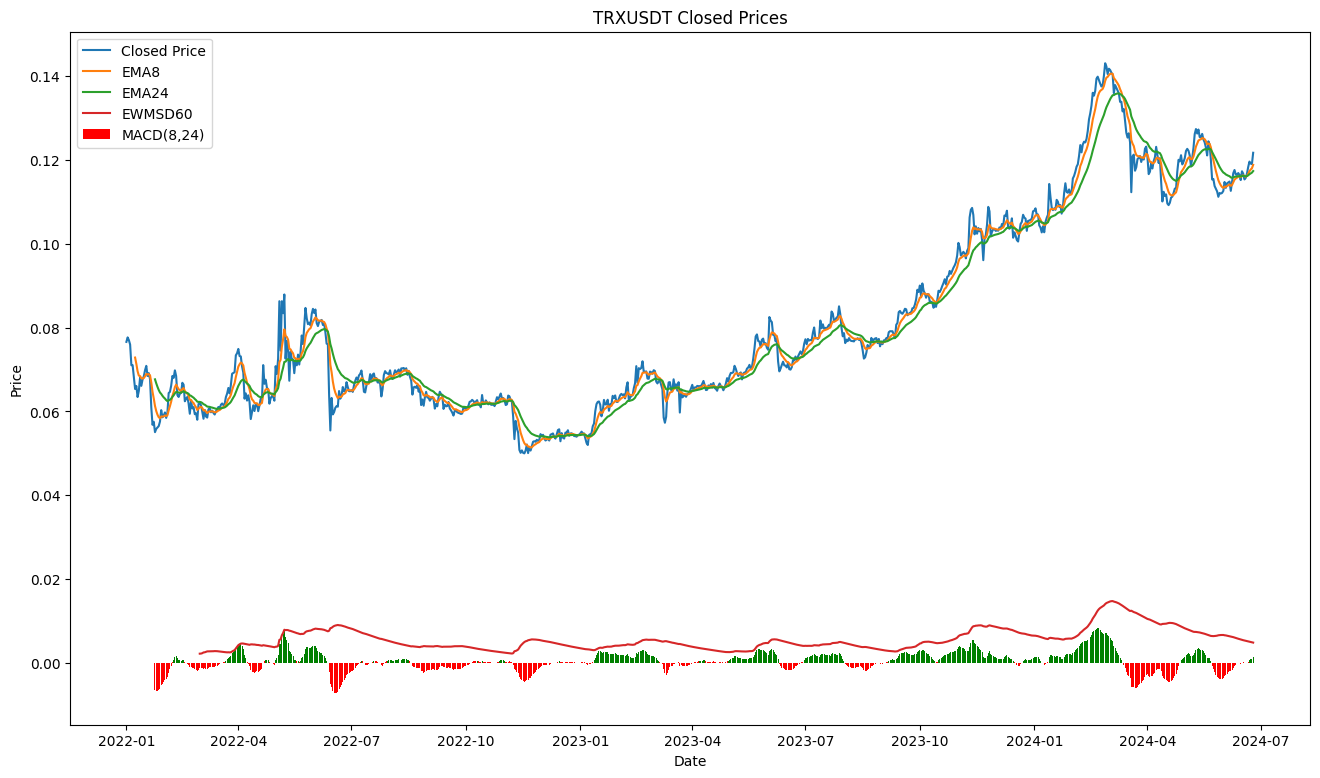

In [29]:
for _, data in data_dic.items():
    data.show_basic()

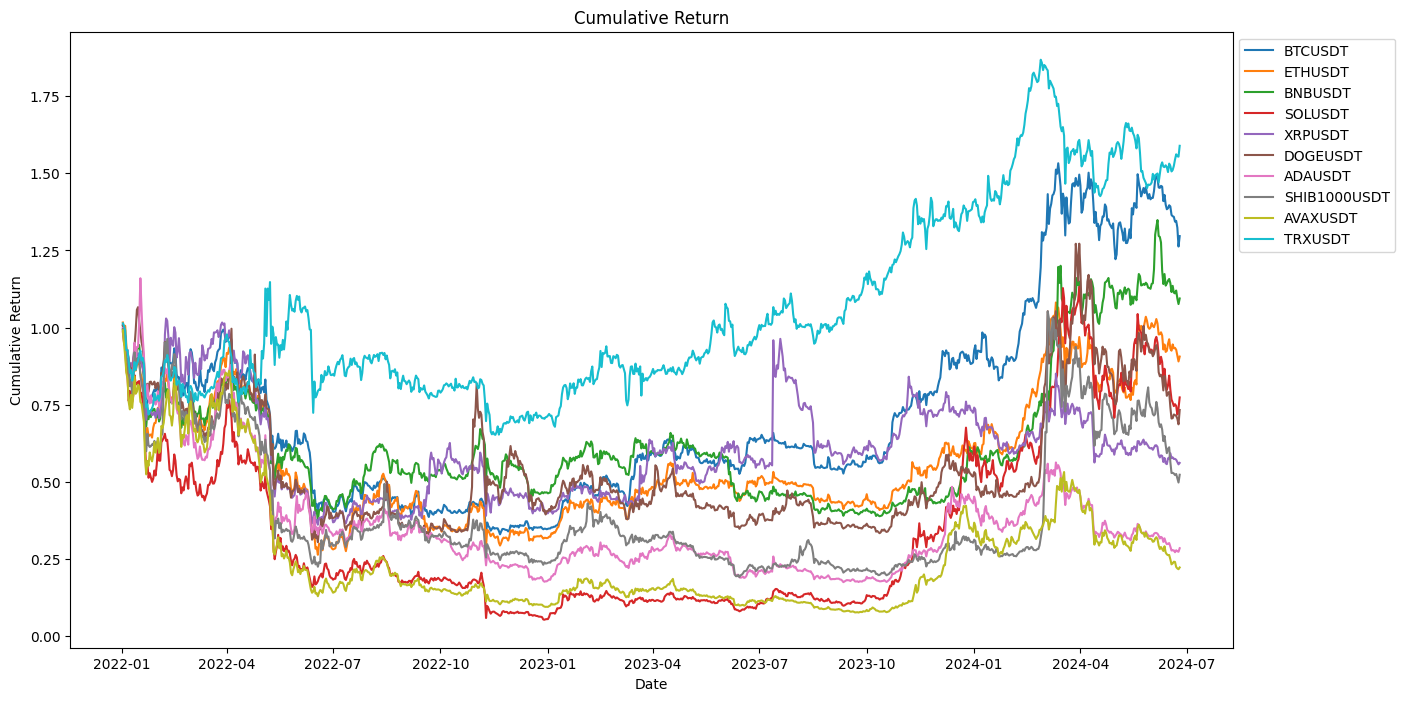

In [30]:
cumulative_returns_dic = {}
for crypto, data in data_dic.items():
    cumulative_returns_dic[crypto] = data.cumulative_returns
compare_cumulative_returns(cumulative_returns_dic)

In [88]:
def Dataloader_X(datas,T,batch_size,train_days):
    names = list(datas.keys())
    days = datas["BTCUSDT"].U.values.shape[0]
    test_days = days - train_days - T
    N_data = []
    for name in names:
        N_data.append(np.array(list(datas[name].U.values),dtype = float))
    N_data_np = np.stack(N_data)
    N_T_data_train = np.array([N_data_np[:,i:i+T] for i in range(train_days)])
    N_T_data_test = np.array([N_data_np[:,i:i+T] for i in range(train_days,days-T+1)])
    A = [torch.tensor(N_T_data_train[i*batch_size:],dtype = torch.float) if i == train_days//batch_size else torch.tensor(N_T_data_train[i*batch_size:(i+1)*batch_size],dtype = torch.float) for i in range(train_days//batch_size+1)]
    B = [torch.tensor(N_T_data_test[i*batch_size:],dtype = torch.float) if i == test_days//batch_size else torch.tensor(N_T_data_test[i*batch_size:(i+1)*batch_size],dtype = torch.float) for i in range(test_days//batch_size+1)]
    print("Size of batched model_input U")
    print("Training set")
    print(f"num of batch : {len(A)}, first batch : {A[0].size()}, last_batch : {A[-1].size()}")
    print("Testing set")
    print(f"num of batch : {len(B)}, first batch : {B[0].size()}, last_batch : {B[-1].size()}")
    # size(num_of_batch, batch_size, N, T, dim_feature)
    return A,B

def Dataloader_X_CPD(datas,T,batch_size,train_days):
    names = list(datas.keys())
    days = datas["BTCUSDT"].U_CPD.values.shape[0]
    test_days = days - train_days - T
    N_data = []
    for name in names:
        N_data.append(np.array(list(datas[name].U_CPD.values),dtype = float))
    N_data_np = np.stack(N_data)
    N_T_data_train = np.array([N_data_np[:,i:i+T] for i in range(train_days)])
    N_T_data_test = np.array([N_data_np[:,i:i+T] for i in range(train_days,days-T+1)])
    A = [torch.tensor(N_T_data_train[i*batch_size:],dtype = torch.float) if i == train_days//batch_size else torch.tensor(N_T_data_train[i*batch_size:(i+1)*batch_size],dtype = torch.float) for i in range(train_days//batch_size+1)]
    B = [torch.tensor(N_T_data_test[i*batch_size:],dtype = torch.float) if i == test_days//batch_size else torch.tensor(N_T_data_test[i*batch_size:(i+1)*batch_size],dtype = torch.float) for i in range(test_days//batch_size+1)]
    print("Size of batched model_input U_CPD")
    print("Training set")
    print(f"num of batch : {len(A)}, first batch : {A[0].size()}, last_batch : {A[-1].size()}")
    print("Testing set")
    print(f"num of batch : {len(B)}, first batch : {B[0].size()}, last_batch : {B[-1].size()}")
    # size(num_of_batch, batch_size, N, T, dim_feature)
    return A,B

def Dataloader_Y1(datas,T,batch_size,train_days):
    names = list(datas.keys())
    days = datas["BTCUSDT"].target.values.shape[0]
    test_days = days - train_days - T
    N_data = []
    for name in names:
        N_data.append(np.array(list(datas[name].target.values[T-1:]),dtype = float))
    N_data_np = np.stack(N_data)
    N_T_data_train = np.array([N_data_np[:,i:i+1] for i in range(train_days)])
    N_T_data_test = np.array([N_data_np[:,i:i+1] for i in range(train_days,days-T+1)])
    A = [torch.tensor(N_T_data_train[i*batch_size:],dtype = torch.float).squeeze() if i == train_days//batch_size else torch.tensor(N_T_data_train[i*batch_size:(i+1)*batch_size],dtype = torch.float).squeeze() for i in range(train_days//batch_size+1)]
    B = [torch.tensor(N_T_data_test[i*batch_size:],dtype = torch.float).squeeze() if i == test_days//batch_size else torch.tensor(N_T_data_test[i*batch_size:(i+1)*batch_size],dtype = torch.float).squeeze() for i in range(test_days//batch_size+1)]
    print("Size of batched target")
    print("Training set")
    print(f"num of batch : {len(A)}, first batch : {A[0].size()}, last_batch : {A[-1].size()}")
    print("Testing set")
    print(f"num of batch : {len(B)}, first batch : {B[0].size()}, last_batch : {B[-1].size()}")
    # size(num_of_batch, batch_size, N)
    return A,B

def Dataloader_Y2(datas,T,batch_size,train_days):
    names = list(datas.keys())
    days = datas["BTCUSDT"].target.values.shape[0]
    test_days = days - train_days - T
    N_data = []
    for name in names:
        N_data.append(np.array(list(datas[name].target.values),dtype = float))
    N_data_np = np.stack(N_data)
    N_T_data_train = np.array([N_data_np[:,i:i+T] for i in range(train_days)])
    N_T_data_test = np.array([N_data_np[:,i:i+T] for i in range(train_days,days-T+1)])
    A = [torch.tensor(N_T_data_train[i*batch_size:],dtype = torch.float) if i == train_days//batch_size else torch.tensor(N_T_data_train[i*batch_size:(i+1)*batch_size],dtype = torch.float) for i in range(train_days//batch_size+1)]
    B = [torch.tensor(N_T_data_test[i*batch_size:],dtype = torch.float) if i == test_days//batch_size else torch.tensor(N_T_data_test[i*batch_size:(i+1)*batch_size],dtype = torch.float) for i in range(test_days//batch_size+1)]
    print("Size of batched target")
    print("Training set")
    print(f"num of batch : {len(A)}, first batch : {A[0].size()}, last_batch : {A[-1].size()}")
    print("Testing set")
    print(f"num of batch : {len(B)}, first batch : {B[0].size()}, last_batch : {B[-1].size()}")
    # size(num_of_batch, batch_size, N, T)
    return A,B

In [25]:
train_days = int(0.8*data_dic["BTCUSDT"].U.values.shape[0])
test_days = data_dic["BTCUSDT"].U.values.shape[0] - train_days - T
print(train_days)
print(test_days)

676
107


In [90]:
print("ED_Transformer datas")
ED_X_train, ED_X_test = Dataloader_X(data_dic,T,batch_size,train_days)
ED_CPD_X_train, ED_CPD_X_test = Dataloader_X_CPD(data_dic,T,batch_size,train_days)
ED_Y_train, ED_Y_test = Dataloader_Y1(data_dic,T,batch_size,train_days)
print("=============================================================")
print("D_Transformer datas")
D_X_train, D_X_test = Dataloader_X(data_dic,T,batch_size,train_days)
D_CPD_X_train, D_CPD_X_test = Dataloader_X_CPD(data_dic,T,batch_size,train_days)
D_Y_train, D_Y_test = Dataloader_Y2(data_dic,T,batch_size,train_days)
print("=============================================================")
print("TFT datas")
TFT_X_train, TFT_X_test = Dataloader_X(data_dic,T,batch_size,train_days)
TFT_Y_train, TFT_Y_test = Dataloader_Y2(data_dic,T,batch_size,train_days)

ED_Transformer datas
Size of batched model_input U
Training set
num of batch : 11, first batch : torch.Size([64, 10, 63, 2]), last_batch : torch.Size([36, 10, 63, 2])
Testing set
num of batch : 2, first batch : torch.Size([64, 10, 63, 2]), last_batch : torch.Size([44, 10, 63, 2])
Size of batched model_input U
Training set
num of batch : 11, first batch : torch.Size([64, 10, 63, 4]), last_batch : torch.Size([36, 10, 63, 4])
Testing set
num of batch : 2, first batch : torch.Size([64, 10, 63, 4]), last_batch : torch.Size([44, 10, 63, 4])
Size of batched target
Training set
num of batch : 11, first batch : torch.Size([64, 10]), last_batch : torch.Size([36, 10])
Testing set
num of batch : 2, first batch : torch.Size([64, 10]), last_batch : torch.Size([44, 10])
D_Transformer datas
Size of batched model_input U
Training set
num of batch : 11, first batch : torch.Size([64, 10, 63, 2]), last_batch : torch.Size([36, 10, 63, 2])
Testing set
num of batch : 2, first batch : torch.Size([64, 10, 63, 

## Training Models

Epoch [10/300], Training Sharpe Loss: -1.29994249,  Testing Sharpe Loss: 0.47126400
Epoch [20/300], Training Sharpe Loss: -1.22680175,  Testing Sharpe Loss: 0.43738189
Epoch [30/300], Training Sharpe Loss: -1.27170706,  Testing Sharpe Loss: 0.43957755
Epoch [40/300], Training Sharpe Loss: -1.41744852,  Testing Sharpe Loss: 0.22425355
Epoch [50/300], Training Sharpe Loss: -1.34613025,  Testing Sharpe Loss: 0.31681615
Epoch [60/300], Training Sharpe Loss: -1.40936387,  Testing Sharpe Loss: 0.26435822
Epoch [70/300], Training Sharpe Loss: -1.33496082,  Testing Sharpe Loss: 0.48445576
Epoch [80/300], Training Sharpe Loss: -1.38772976,  Testing Sharpe Loss: 0.31865519
Epoch [90/300], Training Sharpe Loss: -1.50037003,  Testing Sharpe Loss: 0.46185395
Epoch [100/300], Training Sharpe Loss: -1.42208636,  Testing Sharpe Loss: 0.10789612
Epoch [110/300], Training Sharpe Loss: -1.41705322,  Testing Sharpe Loss: 0.19536462
Epoch [120/300], Training Sharpe Loss: -1.38845253,  Testing Sharpe Loss: 

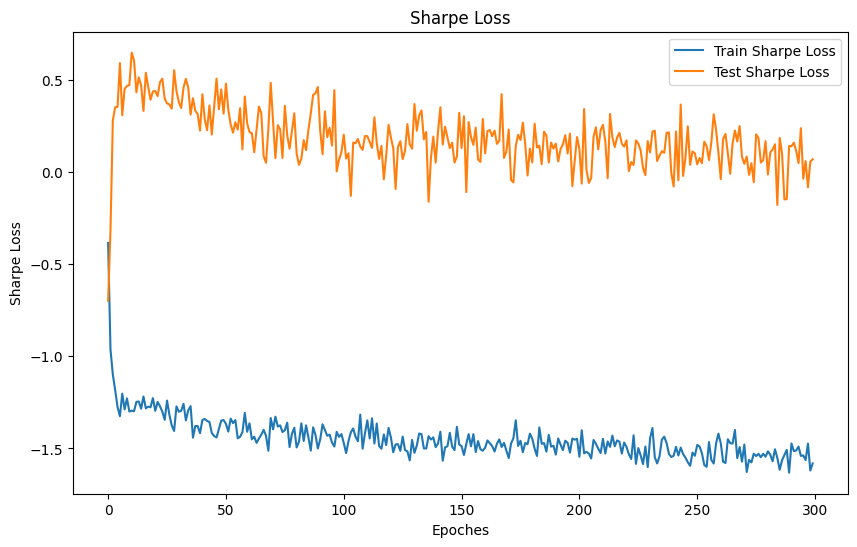

In [91]:
train_ED_transformer(ED_Transformer_model, ED_X_train, ED_Y_train, ED_X_test, ED_Y_test, criterion, optimizer_ED, epoch_scheduler_ED, epoches = 300)

Epoch [10/300], Training Sharpe Loss: -1.07476163,  Testing Sharpe Loss: 0.84117693
Epoch [20/300], Training Sharpe Loss: -1.07130194,  Testing Sharpe Loss: 0.83597887
Epoch [30/300], Training Sharpe Loss: -1.05446780,  Testing Sharpe Loss: 0.81841946
Epoch [40/300], Training Sharpe Loss: -1.08996427,  Testing Sharpe Loss: 0.82303178
Epoch [50/300], Training Sharpe Loss: -1.08214521,  Testing Sharpe Loss: 0.90813625
Epoch [60/300], Training Sharpe Loss: -1.06732762,  Testing Sharpe Loss: 0.79714441
Epoch [70/300], Training Sharpe Loss: -1.08394599,  Testing Sharpe Loss: 0.87367809
Epoch [80/300], Training Sharpe Loss: -1.06320989,  Testing Sharpe Loss: 0.90546238
Epoch [90/300], Training Sharpe Loss: -1.06721914,  Testing Sharpe Loss: 0.88876510
Epoch [100/300], Training Sharpe Loss: -1.06828082,  Testing Sharpe Loss: 0.84055376
Epoch [110/300], Training Sharpe Loss: -1.06070542,  Testing Sharpe Loss: 0.83058763
Epoch [120/300], Training Sharpe Loss: -1.08020902,  Testing Sharpe Loss: 

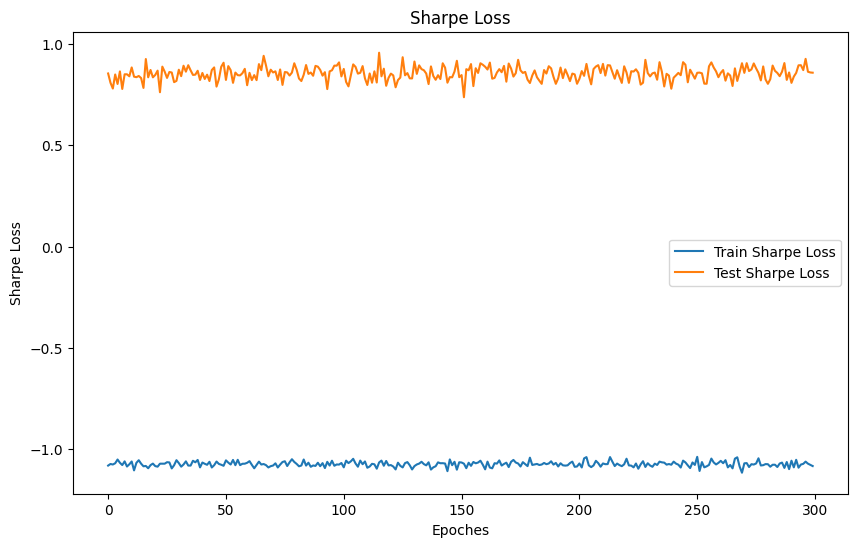

In [92]:
train_ED_transformer(ED_Transformer_model_CPD, ED_CPD_X_train, ED_Y_train, ED_CPD_X_test, ED_Y_test, criterion, optimizer_ED_CPD, epoch_scheduler_ED_CPD, epoches = 300)

Epoch [10/300], Train Sharpe Loss: -0.89684522, Test Sharpe Loss: -0.89440000
Epoch [20/300], Train Sharpe Loss: -0.94841349, Test Sharpe Loss: -0.84663904
Epoch [30/300], Train Sharpe Loss: -1.01706743, Test Sharpe Loss: -0.80254674
Epoch [40/300], Train Sharpe Loss: -1.08052230, Test Sharpe Loss: -0.81037116
Epoch [50/300], Train Sharpe Loss: -1.13076389, Test Sharpe Loss: -0.83905149
Epoch [60/300], Train Sharpe Loss: -1.15344024, Test Sharpe Loss: -0.86309576
Epoch [70/300], Train Sharpe Loss: -1.17554104, Test Sharpe Loss: -0.90528387
Epoch [80/300], Train Sharpe Loss: -1.17361498, Test Sharpe Loss: -0.94051754
Epoch [90/300], Train Sharpe Loss: -1.16466260, Test Sharpe Loss: -0.92842674
Epoch [100/300], Train Sharpe Loss: -1.18307030, Test Sharpe Loss: -0.94374317
Epoch [110/300], Train Sharpe Loss: -1.21632802, Test Sharpe Loss: -0.93961155
Epoch [120/300], Train Sharpe Loss: -1.19996619, Test Sharpe Loss: -0.92442828
Epoch [130/300], Train Sharpe Loss: -1.20485103, Test Sharpe 

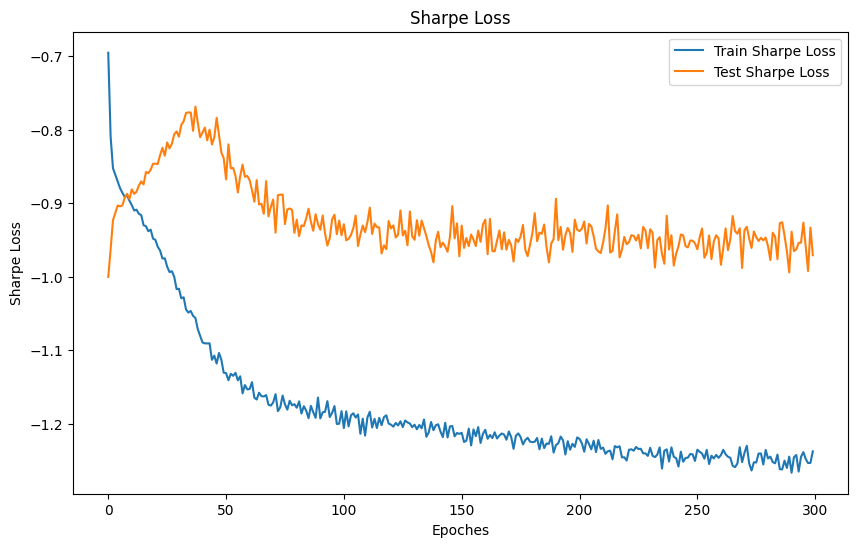

In [93]:
train_D_transformer(D_Transformer_model, D_X_train, D_Y_train, D_X_test, D_Y_test, criterion, optimizer_D, epoch_scheduler_D, epoches = 300)

Epoch [10/300], Train Sharpe Loss: 0.47002232, Test Sharpe Loss: 0.72439861
Epoch [20/300], Train Sharpe Loss: 0.45984948, Test Sharpe Loss: 0.70216894
Epoch [30/300], Train Sharpe Loss: 0.46055639, Test Sharpe Loss: 0.70151114
Epoch [40/300], Train Sharpe Loss: 0.46333382, Test Sharpe Loss: 0.69757664
Epoch [50/300], Train Sharpe Loss: 0.46185407, Test Sharpe Loss: 0.71733671
Epoch [60/300], Train Sharpe Loss: 0.45839933, Test Sharpe Loss: 0.71916902
Epoch [70/300], Train Sharpe Loss: 0.45695555, Test Sharpe Loss: 0.71154004
Epoch [80/300], Train Sharpe Loss: 0.46499366, Test Sharpe Loss: 0.69536042
Epoch [90/300], Train Sharpe Loss: 0.47148120, Test Sharpe Loss: 0.72987783
Epoch [100/300], Train Sharpe Loss: 0.46394855, Test Sharpe Loss: 0.69956255
Epoch [110/300], Train Sharpe Loss: 0.45593312, Test Sharpe Loss: 0.70630103
Epoch [120/300], Train Sharpe Loss: 0.46465960, Test Sharpe Loss: 0.71525884
Epoch [130/300], Train Sharpe Loss: 0.45950222, Test Sharpe Loss: 0.69302750
Epoch [1

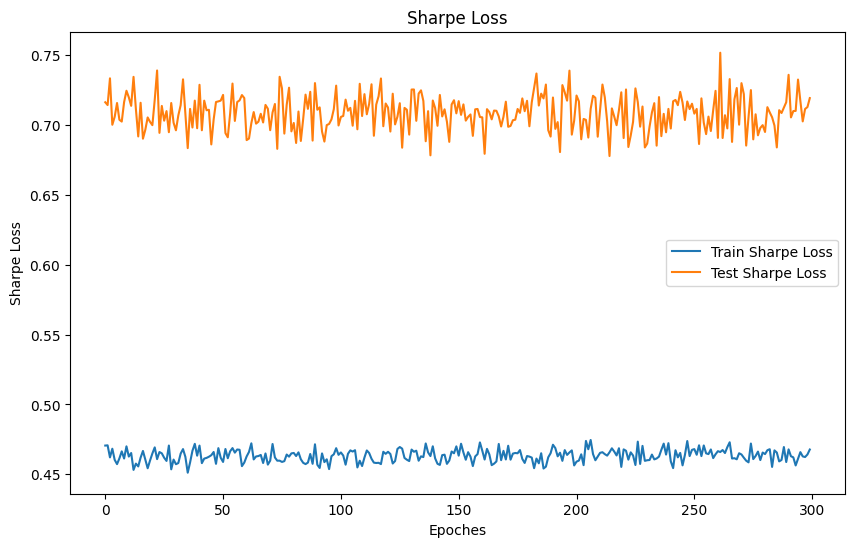

In [94]:
train_D_transformer(D_Transformer_model_CPD, D_CPD_X_train, D_Y_train, D_CPD_X_test, D_Y_test, criterion, optimizer_D_CPD, epoch_scheduler_D_CPD, epoches = 300)

Epoch [1/100], Train Sharpe Loss: 0.02498399, Test Sharpe Loss: -0.03494322
Epoch [2/100], Train Sharpe Loss: 0.02181996, Test Sharpe Loss: -0.04671939
Epoch [3/100], Train Sharpe Loss: 0.02702194, Test Sharpe Loss: -0.04926174
Epoch [4/100], Train Sharpe Loss: 0.02032877, Test Sharpe Loss: -0.03328637
Epoch [5/100], Train Sharpe Loss: 0.02557984, Test Sharpe Loss: -0.04445651
Epoch [6/100], Train Sharpe Loss: 0.02499674, Test Sharpe Loss: -0.04770280
Epoch [7/100], Train Sharpe Loss: 0.02406863, Test Sharpe Loss: -0.04764958
Epoch [8/100], Train Sharpe Loss: 0.02729147, Test Sharpe Loss: -0.05417139
Epoch [9/100], Train Sharpe Loss: 0.02272980, Test Sharpe Loss: -0.03807566
Epoch [10/100], Train Sharpe Loss: 0.02097356, Test Sharpe Loss: -0.04470033
Epoch [11/100], Train Sharpe Loss: 0.02707986, Test Sharpe Loss: -0.04871441
Epoch [12/100], Train Sharpe Loss: 0.02140148, Test Sharpe Loss: -0.04479139
Epoch [13/100], Train Sharpe Loss: 0.02155455, Test Sharpe Loss: -0.03573938
Epoch [1

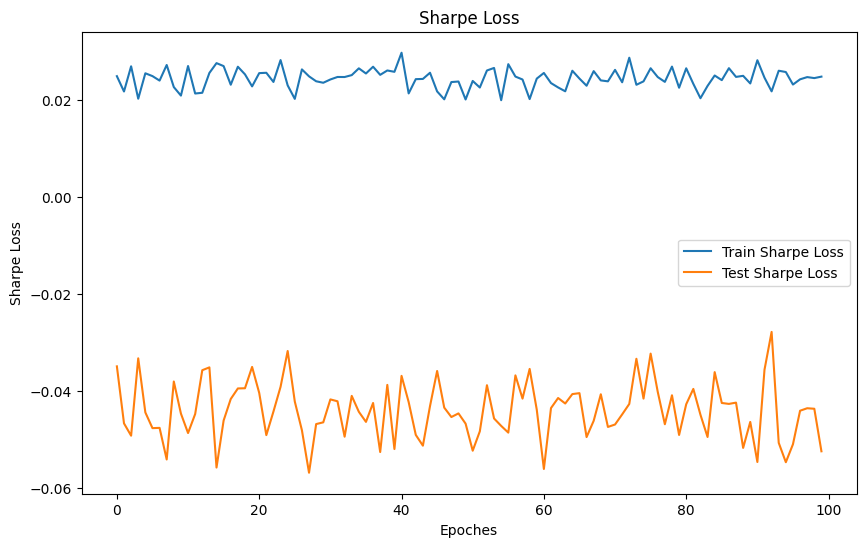

In [100]:
train_TFT(TFT_model, TFT_X_train, TFT_Y_train, TFT_X_test, TFT_Y_test, criterion, optimizer_TFT, epoch_scheduler_TFT, epoches = 100)

## Result

In [106]:
def model_result(model,T,datas):
    model.eval()
    dates = datas.index
    data_list=[]
    for i in range(datas.shape[0]-T):
        data_list.append(np.array(list(datas.values), dtype = float)[i:i+T])
    result=[]
    for data in data_list:
        result.append(model(torch.tensor(data, dtype = torch.float).unsqueeze(0)).detach().numpy().squeeze())
    result = pd.Series(result, index=dates[T:])
    return result

def ED_Transformer_result(T, datas):
    ED_Transformer_model.eval()
    dates = datas.index
    data_list=[]
    for i in range(datas.shape[0]-T):
        data_list.append(np.array(list(datas.values), dtype = float)[i:i+T])
    result=[]
    for data in data_list:
        result.append(ED_Transformer_model(torch.tensor(data, dtype = torch.float).unsqueeze(0)).detach().numpy().squeeze())
    result = pd.Series(result, index=dates[T:])
    return result

def ED_Transformer_CPD_result(T, datas):
    ED_Transformer_model_CPD.eval()
    dates = datas.index
    data_list=[]
    for i in range(datas.shape[0]-T):
        data_list.append(np.array(list(datas.values), dtype = float)[i:i+T])
    result=[]
    for data in data_list:
        result.append(ED_Transformer_model_CPD(torch.tensor(data, dtype = torch.float).unsqueeze(0)).detach().numpy().squeeze())
    result = pd.Series(result, index=dates[T:])
    return result

def D_Transformer_result(T, datas):
    D_Transformer_model.eval()
    dates = datas.index
    data_list=[]
    for i in range(datas.shape[0]-T):
        data_list.append(np.array(list(datas.values), dtype = float)[i:i+T])
    result=[]
    for data in data_list:
        result.append(D_Transformer_model(torch.tensor(data, dtype = torch.float).unsqueeze(0)).detach().numpy().squeeze()[-1])
    result = pd.Series(result, index=dates[T:])
    return result

def D_Transformer_CPD_result(T, datas):
    D_Transformer_model_CPD.eval()
    dates = datas.index
    data_list=[]
    for i in range(datas.shape[0]-T):
        data_list.append(np.array(list(datas.values), dtype = float)[i:i+T])
    result=[]
    for data in data_list:
        result.append(D_Transformer_model_CPD(torch.tensor(data, dtype = torch.float).unsqueeze(0)).detach().numpy().squeeze()[-1])
    result = pd.Series(result, index=dates[T:])
    return result

def TFT_result(T, datas):
    TFT_model.eval()
    dates = datas.index
    data_list=[]
    for i in range(datas.shape[0]-T):
        data_list.append(np.array(list(datas.values), dtype = float)[i:i+T])
    result=[]
    for data in data_list:
        result.append(D_Transformer_model(torch.tensor(data, dtype = torch.float).unsqueeze(0)).detach().numpy().squeeze()[-1])
    result = pd.Series(result, index=dates[T:])
    return result

def show_position(data_dic):
    for crypto, data in data_dic.items():
        plt.figure(figsize=(10, 5))
        plt.plot(data.U.index[train_days:], data.baz_strategy()[data.U.index[train_days:]], label="baz", color = "cornflowerblue")
        plt.plot(data.U.index[train_days:], ED_Transformer_result(T, data.U[train_days-T:]), label="ED_Transformer", color = "gold")
        plt.plot(data.U.index[train_days:], ED_Transformer_CPD_result(T, data.U_CPD[train_days-T:]), label="ED_Transformer_CPD", color = "yellow")
        plt.plot(data.U.index[train_days:], D_Transformer_result(T, data.U[train_days-T:]), label="D_Transformer", color = "deeppink")
        plt.plot(data.U.index[train_days:], D_Transformer_CPD_result(T, data.U_CPD[train_days-T:]), label="D_Transformer_CPD", color = "pink")
        plt.plot(data.U.index[train_days:], TFT_result(T, data.U[train_days-T:]), label="TFT", color = "slateblue")
        colors = ['green' if x > 0 else 'red' for x in data.normalized_MACD_closed_price[data.U.index[train_days:]]]
        plt.bar(data.U.index[train_days:], data.normalized_MACD_closed_price[data.U.index[train_days:]], label=f"MACD({S},{L})", color=colors, width=0.8)
        plt.title(f"{crypto} Position size")
        plt.xlabel('Date')
        plt.ylabel('Size of Position')
        plt.legend()
        plt.show()
        
def show_portfolio(data_dic):
    
    baz_portfolio = []
    ED_Transformer_portfolio = []
    ED_Transformer_CPD_portfolio = []
    D_Transformer_portfolio = []
    D_Transformer_CPD_portfolio = []
    TFT_portfolio = []
    
    for _, data in data_dic.items():
        # calculate the position
        baz_pos = data.baz_strategy()[data.U.index[train_days+T:]]
        ED_Transformer_pos = ED_Transformer_result(T, data.U[train_days:])
        ED_Transformer_CPD_pos = ED_Transformer_CPD_result(T, data.U_CPD[train_days:])
        D_Transformer_pos = D_Transformer_result(T, data.U[train_days:])
        D_Transformer_CPD_pos = D_Transformer_CPD_result(T, data.U_CPD[train_days:])
        TFT_pos = TFT_result(T, data.U[train_days:])
        # calculate the portfolio
        baz_portfolio.append((baz_pos[:-1].values * data.returns[data.U.index[train_days+T+1:]] + 1)/len(data_dic))
        ED_Transformer_portfolio.append((ED_Transformer_pos[:-1].values * (data.returns[data.U.index[train_days+T+1:]]) + 1)/len(data_dic))
        ED_Transformer_CPD_portfolio.append((ED_Transformer_CPD_pos[:-1].values * (data.returns[data.U.index[train_days+T+1:]]) + 1)/len(data_dic))
        D_Transformer_portfolio.append((D_Transformer_pos[:-1].values * (data.returns[data.U.index[train_days+T+1:]]) + 1)/len(data_dic))
        D_Transformer_CPD_portfolio.append((D_Transformer_CPD_pos[:-1].values * (data.returns[data.U.index[train_days+T+1:]]) + 1)/len(data_dic))
        TFT_portfolio.append((TFT_pos[:-1].values * (data.returns[data.U.index[train_days+T+1:]]) + 1)/len(data_dic))
        
    baz_portfolio = np.array(baz_portfolio).T
    baz_portfolio = np.array([sum(sub) for sub in baz_portfolio])
    baz_portfolio = baz_portfolio.cumprod()
    ED_Transformer_portfolio = np.array(ED_Transformer_portfolio).T
    ED_Transformer_portfolio = np.array([sum(sub) for sub in ED_Transformer_portfolio])
    ED_Transformer_portfolio = ED_Transformer_portfolio.cumprod()
    ED_Transformer_CPD_portfolio = np.array(ED_Transformer_CPD_portfolio).T
    ED_Transformer_CPD_portfolio = np.array([sum(sub) for sub in ED_Transformer_CPD_portfolio])
    ED_Transformer_CPD_portfolio = ED_Transformer_CPD_portfolio.cumprod()
    D_Transformer_portfolio = np.array(D_Transformer_portfolio).T
    D_Transformer_portfolio = np.array([sum(sub) for sub in D_Transformer_portfolio])
    D_Transformer_portfolio = D_Transformer_portfolio.cumprod()
    D_Transformer_CPD_portfolio = np.array(D_Transformer_CPD_portfolio).T
    D_Transformer_CPD_portfolio = np.array([sum(sub) for sub in D_Transformer_CPD_portfolio])
    D_Transformer_CPD_portfolio = D_Transformer_CPD_portfolio.cumprod()
    TFT_portfolio = np.array(TFT_portfolio).T
    TFT_portfolio = np.array([sum(sub) for sub in TFT_portfolio])
    TFT_portfolio = TFT_portfolio.cumprod()
        
    plt.figure(figsize=(16, 9))
    plt.plot(data.U.index[train_days+T+1:], baz_portfolio, label="baz", color = "cornflowerblue")
    plt.plot(data.U.index[train_days+T+1:], ED_Transformer_portfolio, label="ED_Transformer", color = "gold")
    plt.plot(data.U.index[train_days+T+1:], ED_Transformer_CPD_portfolio, label="ED_Transformer_CPD", color = "blue")
    plt.plot(data.U.index[train_days+T+1:], D_Transformer_portfolio, label="D_Transformer", color = "deeppink")
    plt.plot(data.U.index[train_days+T+1:], D_Transformer_CPD_portfolio, label="D_Transformer_CPD", color = "pink")
    plt.plot(data.U.index[train_days+T+1:], TFT_portfolio, label="TFT", color = "slateblue")
    plt.title("Portfolio Return")
    plt.xlabel('Date')
    plt.ylabel('Cummulative Return')
    plt.legend()
    plt.show()
  


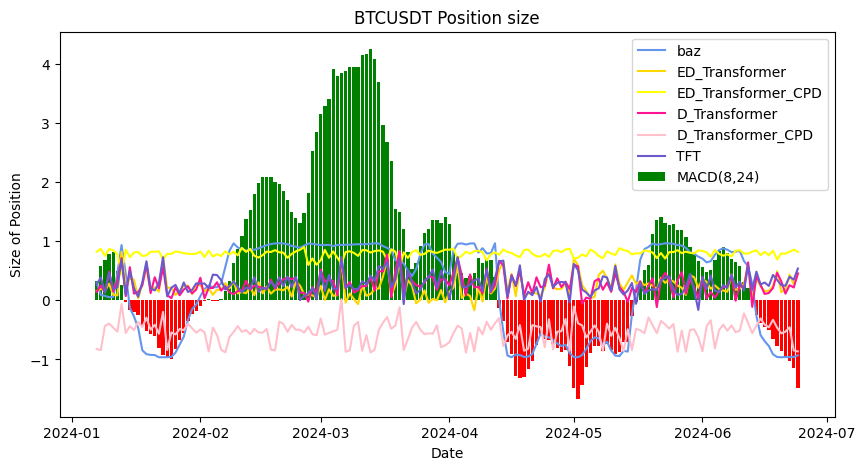

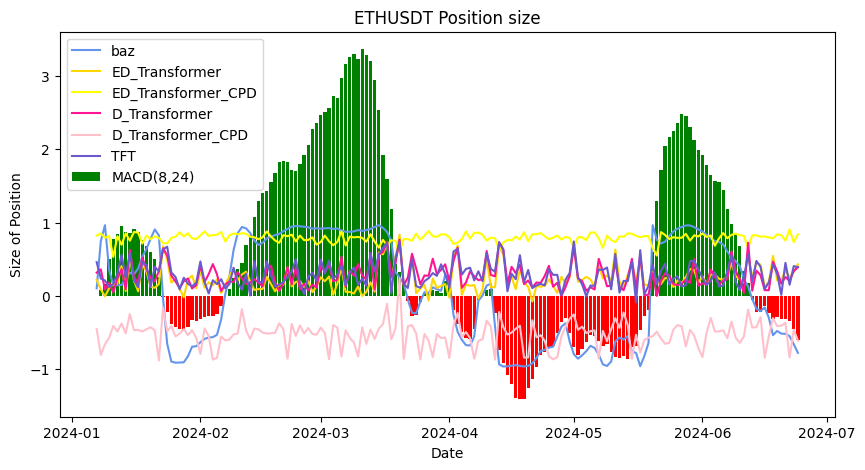

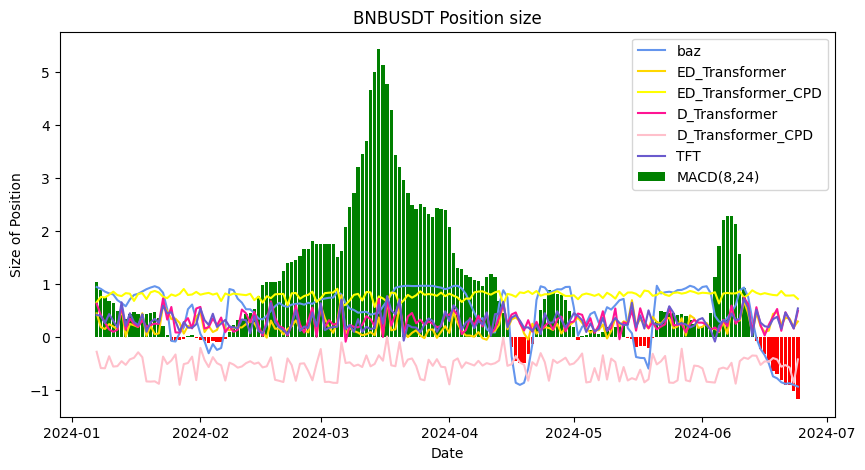

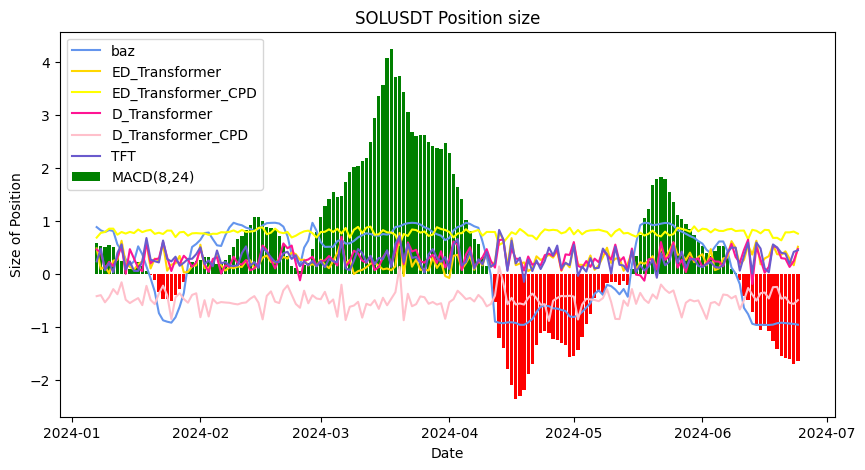

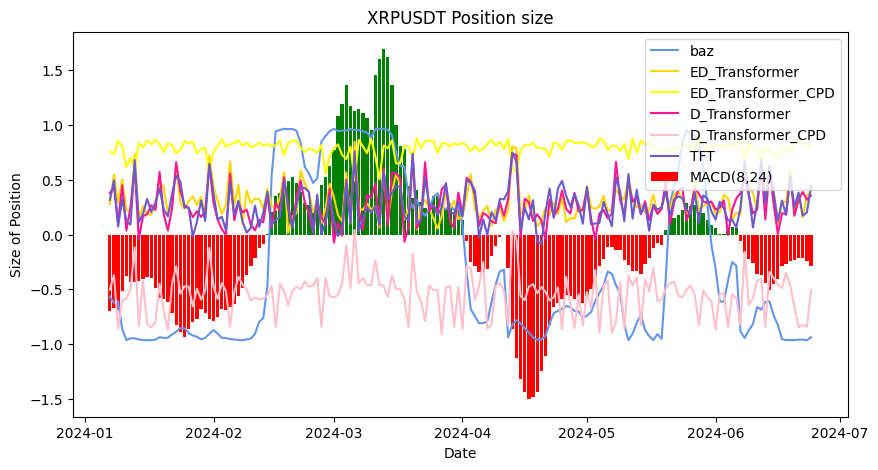

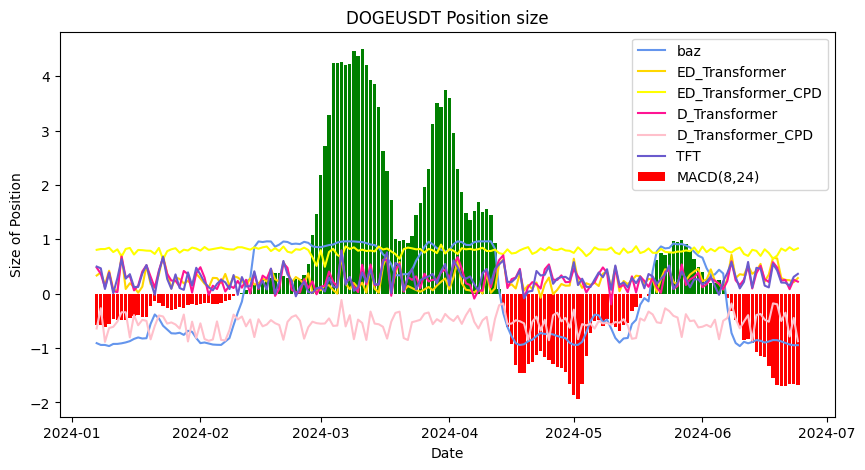

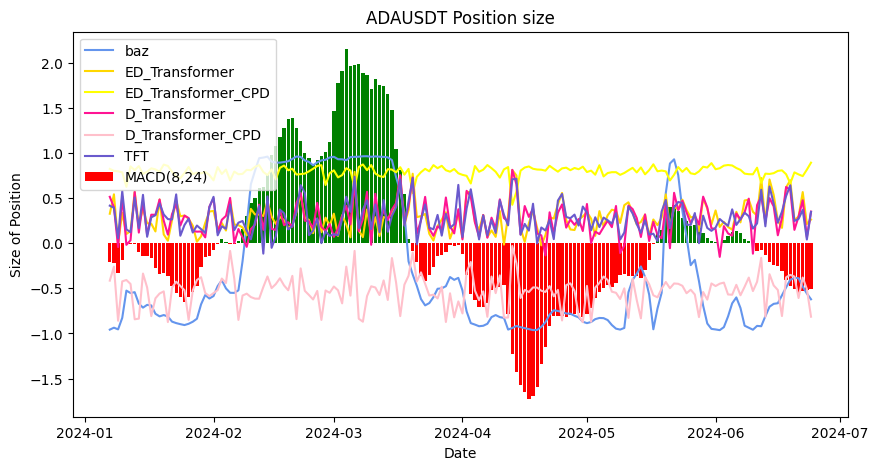

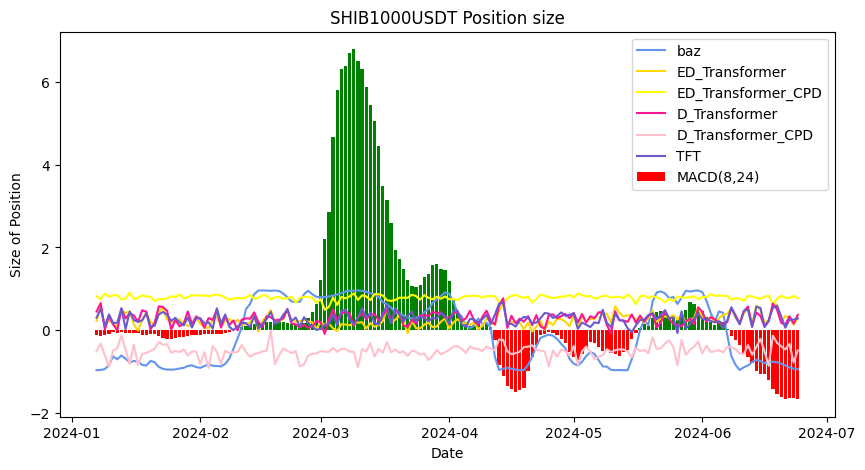

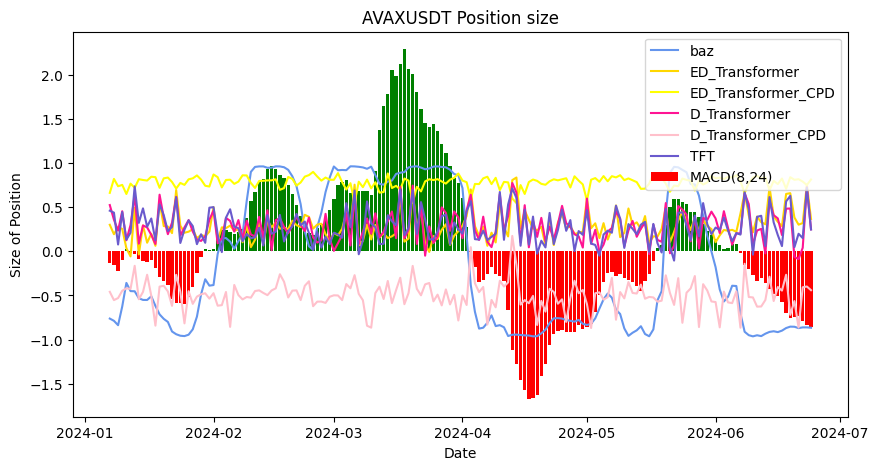

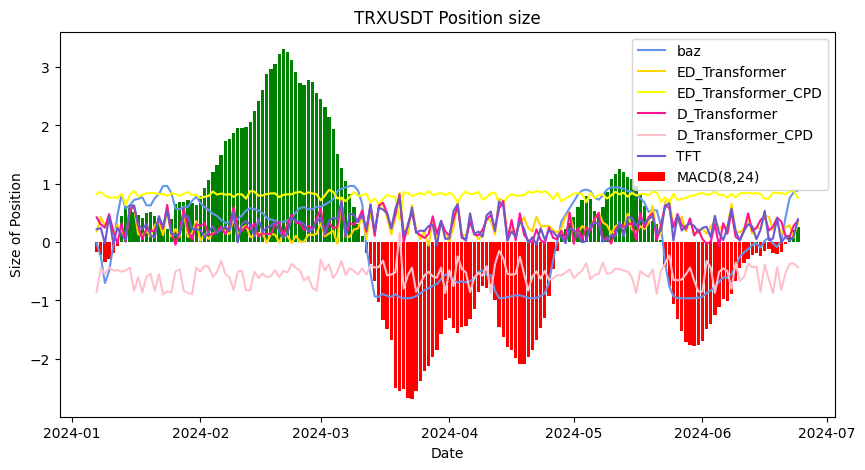

In [104]:
show_position(data_dic)

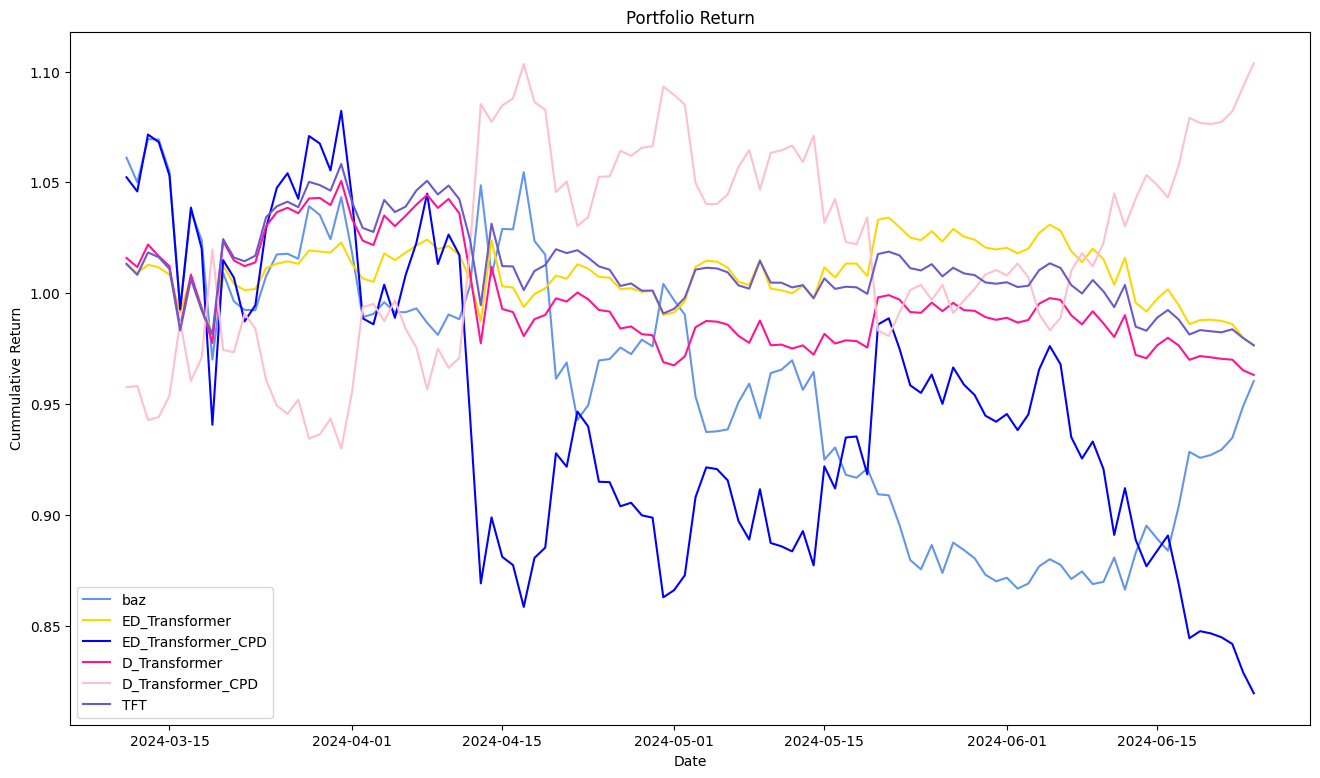

In [107]:
show_portfolio(data_dic)

In [113]:
def cal_return(data_dic):
    baz_portfolio = []
    ED_Transformer_portfolio = []
    ED_Transformer_CPD_portfolio = []
    D_Transformer_portfolio = []
    D_Transformer_CPD_portfolio = []
    TFT_portfolio = []
    
    for _, data in data_dic.items():
        # calculate the position
        baz_pos = data.baz_strategy()[data.U.index[train_days+T:]]
        ED_Transformer_pos = ED_Transformer_result(T, data.U[train_days:])
        ED_Transformer_CPD_pos = ED_Transformer_CPD_result(T, data.U_CPD[train_days:])
        D_Transformer_pos = D_Transformer_result(T, data.U[train_days:])
        D_Transformer_CPD_pos = D_Transformer_CPD_result(T, data.U_CPD[train_days:])
        TFT_pos = TFT_result(T, data.U[train_days:])
        # calculate the portfolio
        baz_portfolio.append((baz_pos[:-1].values * data.returns[data.U.index[train_days+T+1:]] + 1)/len(data_dic))
        ED_Transformer_portfolio.append((ED_Transformer_pos[:-1].values * (data.returns[data.U.index[train_days+T+1:]]) + 1)/len(data_dic))
        ED_Transformer_CPD_portfolio.append((ED_Transformer_CPD_pos[:-1].values * (data.returns[data.U.index[train_days+T+1:]]) + 1)/len(data_dic))
        D_Transformer_portfolio.append((D_Transformer_pos[:-1].values * (data.returns[data.U.index[train_days+T+1:]]) + 1)/len(data_dic))
        D_Transformer_CPD_portfolio.append((D_Transformer_CPD_pos[:-1].values * (data.returns[data.U.index[train_days+T+1:]]) + 1)/len(data_dic))
        TFT_portfolio.append((TFT_pos[:-1].values * (data.returns[data.U.index[train_days+T+1:]]) + 1)/len(data_dic))
        
    baz_portfolio = np.array(baz_portfolio).T
    baz_portfolio = np.array([sum(sub) for sub in baz_portfolio])

    ED_Transformer_portfolio = np.array(ED_Transformer_portfolio).T
    ED_Transformer_portfolio = np.array([sum(sub) for sub in ED_Transformer_portfolio])

    ED_Transformer_CPD_portfolio = np.array(ED_Transformer_CPD_portfolio).T
    ED_Transformer_CPD_portfolio = np.array([sum(sub) for sub in ED_Transformer_CPD_portfolio])

    D_Transformer_portfolio = np.array(D_Transformer_portfolio).T
    D_Transformer_portfolio = np.array([sum(sub) for sub in D_Transformer_portfolio])

    D_Transformer_CPD_portfolio = np.array(D_Transformer_CPD_portfolio).T
    D_Transformer_CPD_portfolio = np.array([sum(sub) for sub in D_Transformer_CPD_portfolio])

    TFT_portfolio = np.array(TFT_portfolio).T
    TFT_portfolio = np.array([sum(sub) for sub in TFT_portfolio])

    df = pd.DataFrame(baz_portfolio-1,columns=['baz'])
    df['Date'] = data.U.index[train_days+T+1:]
    df['ED_Transformer'] = ED_Transformer_portfolio-1
    df['ED_Transformer_CPD'] = ED_Transformer_CPD_portfolio-1
    df['D_Transformer'] = D_Transformer_portfolio-1
    df['D_Transformer_CPD'] = D_Transformer_CPD_portfolio-1
    df['TFT'] = TFT_portfolio-1

    df.set_index('Date', inplace=True)
    return df
df = cal_return(data_dic)

In [111]:
import quantstats as qs

c:\Users\林元鴻\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\林元鴻\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\林元鴻\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old be

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2024-03-11   2024-03-11
End Period                 2024-06-24   2024-06-24
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          -3.97%       -2.65%
CAGR﹪                     -9.26%       -6.23%

Sharpe                     -0.17        -0.41
Prob. Sharpe Ratio         45.64%       39.71%
Smart Sharpe               -0.12        -0.28
Sortino                    -0.23        -0.64
Smart Sortino              -0.16        -0.45
Sortino/√2                 -0.16        -0.46
Smart Sortino/√2           -0.11        -0.32
Omega                      0.93         0.93

Max Drawdown               -19.01%      -5.48%
Longest DD Days            103          35
Volatility (ann.)          30.13%       13.39%
R^2                        0.01         0.01
Information Ratio          -0.0         -0.0
Calmar         

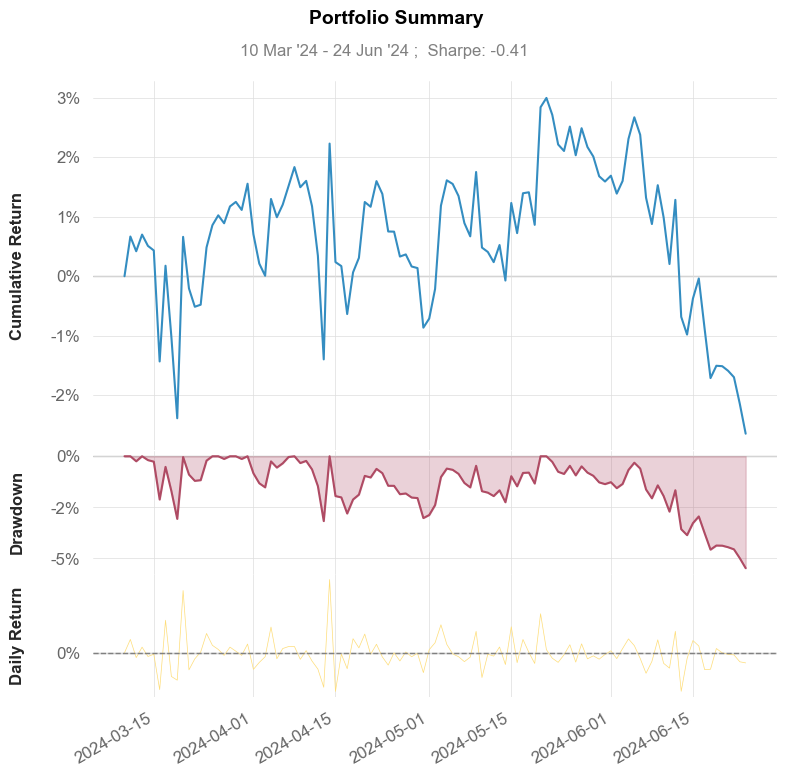

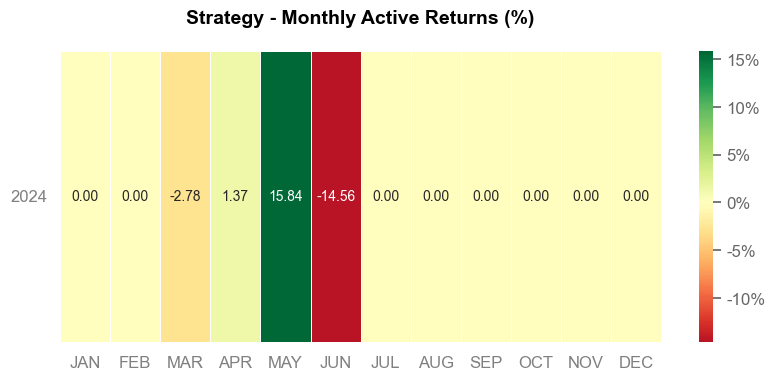

In [124]:
qs.reports.metrics(df['ED_Transformer'],benchmark=df['baz'],mode='full')
qs.reports.plots(df['ED_Transformer'],benchmark=df['baz'],mode='basic',benchmark_title = 'baz')

c:\Users\林元鴻\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\林元鴻\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\林元鴻\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old be

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2024-03-11   2024-03-11
End Period                 2024-06-24   2024-06-24
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          -3.97%       -17.73%
CAGR﹪                     -9.26%       -37.4%

Sharpe                     -0.17        -0.9
Prob. Sharpe Ratio         45.64%       28.07%
Smart Sharpe               -0.15        -0.79
Sortino                    -0.23        -1.24
Smart Sortino              -0.21        -1.09
Sortino/√2                 -0.16        -0.88
Smart Sortino/√2           -0.15        -0.77
Omega                      0.85         0.85

Max Drawdown               -19.01%      -24.19%
Longest DD Days            103          85
Volatility (ann.)          30.13%       41.83%
R^2                        0.0          0.0
Information Ratio          -0.04        -0.04
Calmar        

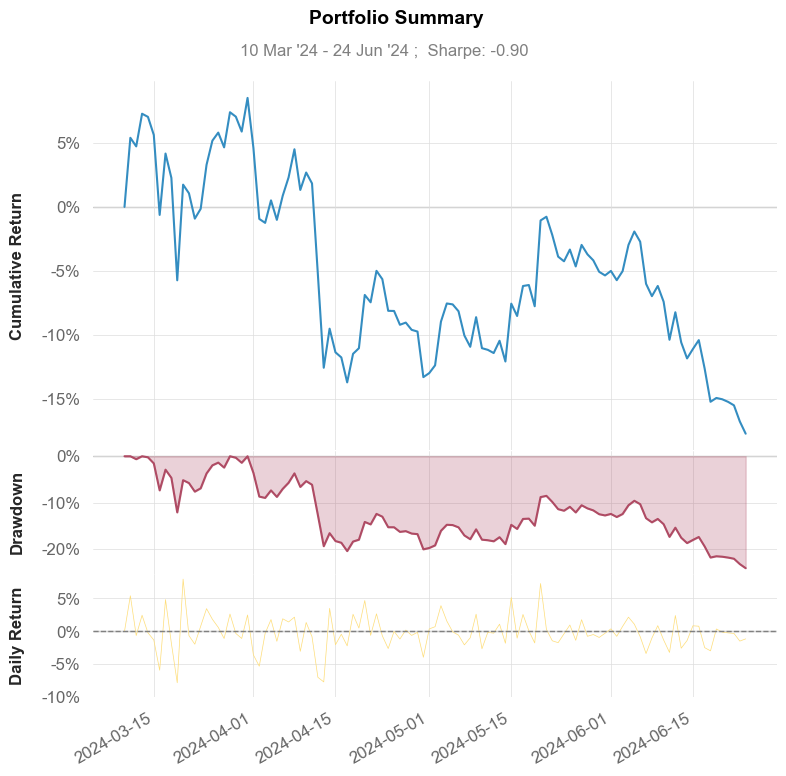

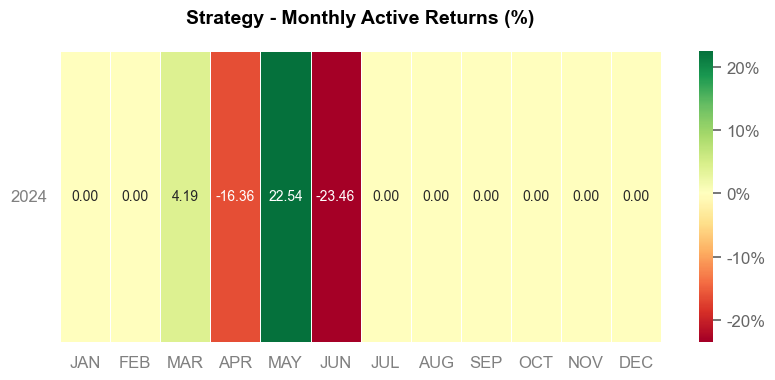

In [123]:
qs.reports.metrics(df['ED_Transformer_CPD'],benchmark=df['baz'],mode='full')
qs.reports.plots(df['ED_Transformer_CPD'],benchmark=df['baz'],mode='basic',benchmark_title = 'baz')

                    Benchmark    Strategy
------------------  -----------  ----------
Start Period        2024-03-11   2024-03-11
End Period          2024-06-24   2024-06-24
Risk-Free Rate      0.0%         0.0%
Time in Market      100.0%       100.0%

Cumulative Return   -17.73%      -2.65%
CAGR﹪              -37.4%       -6.23%

Sharpe              -0.9         -0.41
Prob. Sharpe Ratio  28.07%       39.71%
Sortino             -1.24        -0.64
Sortino/√2          -0.88        -0.46
Omega               0.93         0.93

Max Drawdown        -24.19%      -5.48%
Longest DD Days     85           35

Gain/Pain Ratio     -0.15        -0.07
Gain/Pain (1M)      -0.46        -0.36

Payoff Ratio        1.24         1.33
Profit Factor       0.85         0.93
Common Sense Ratio  0.99         0.98
CPC Index           0.43         0.51
Tail Ratio          1.16         1.05
Outlier Win Ratio   2.37         7.69
Outlier Loss Ratio  2.78         9.41

MTD                 -13.07%      -4.17%
3M      

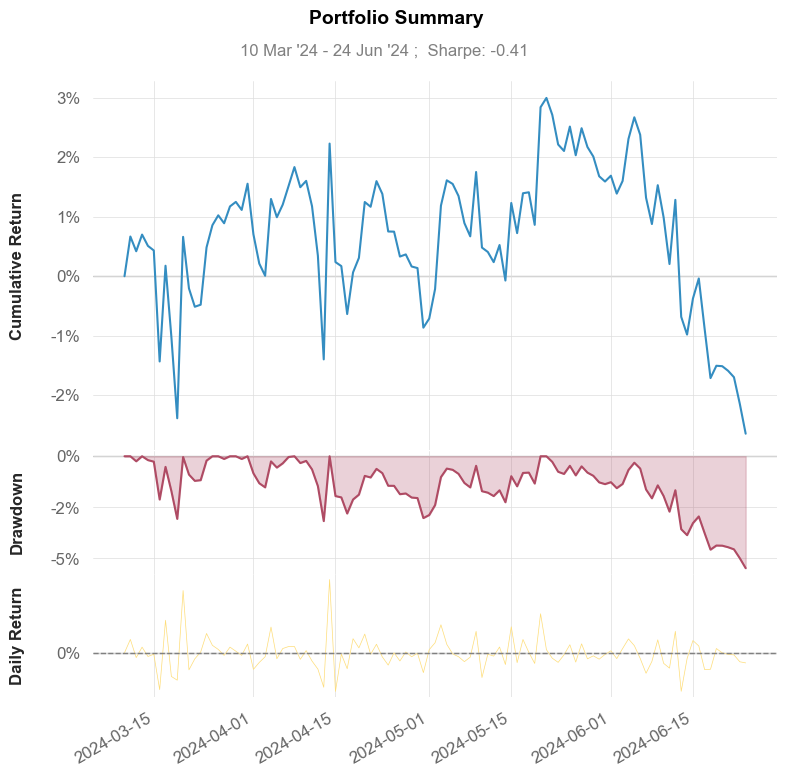

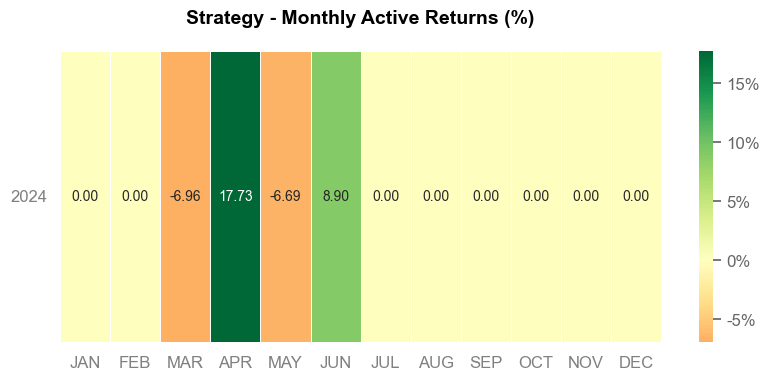

In [116]:
qs.reports.metrics(df['ED_Transformer'],benchmark=df['ED_Transformer_CPD'],mode='full')
qs.reports.plots(df['ED_Transformer'],benchmark=df['ED_Transformer_CPD'],mode='basic',benchmark_title = 'baz')

c:\Users\林元鴻\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\林元鴻\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\林元鴻\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old be

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2024-03-11   2024-03-11
End Period                 2024-06-24   2024-06-24
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          -3.97%       -3.3%
CAGR﹪                     -9.26%       -7.73%

Sharpe                     -0.17        -0.41
Prob. Sharpe Ratio         45.64%       39.76%
Smart Sharpe               -0.12        -0.29
Sortino                    -0.23        -0.63
Smart Sortino              -0.17        -0.45
Sortino/√2                 -0.16        -0.44
Smart Sortino/√2           -0.12        -0.32
Omega                      0.92         0.92

Max Drawdown               -19.01%      -8.29%
Longest DD Days            103          85
Volatility (ann.)          30.13%       16.33%
R^2                        0.0          0.0
Information Ratio          -0.0         -0.0
Calmar           

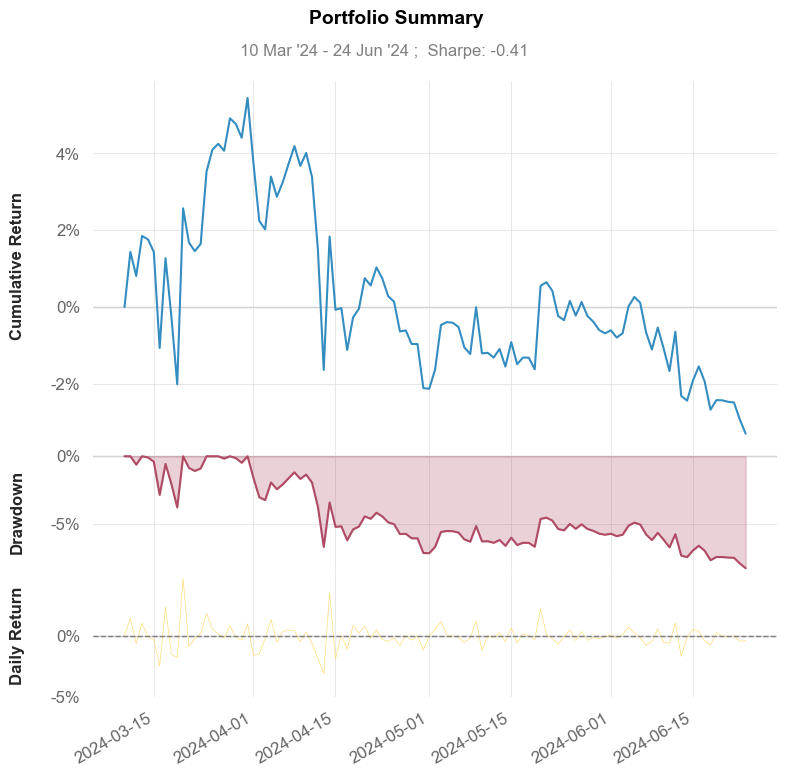

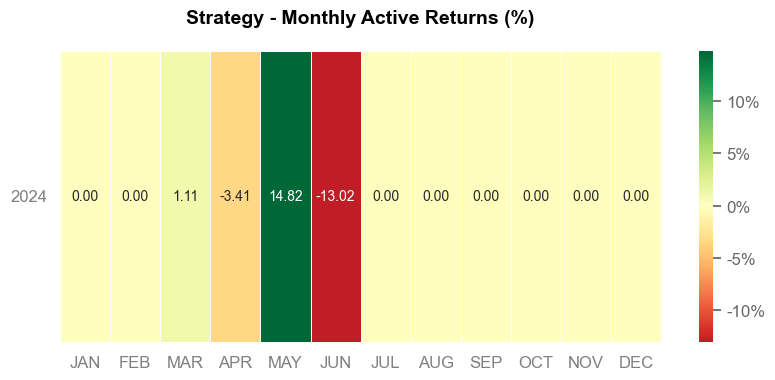

In [122]:
qs.reports.metrics(df['D_Transformer'],benchmark=df['baz'],mode='full')
qs.reports.plots(df['D_Transformer'],benchmark=df['baz'],mode='basic',benchmark_title = 'baz')

c:\Users\林元鴻\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\林元鴻\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\林元鴻\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old be

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2024-03-11   2024-03-11
End Period                 2024-06-24   2024-06-24
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          -3.97%       11.65%
CAGR﹪                     -9.26%       30.27%

Sharpe                     -0.17        1.07
Prob. Sharpe Ratio         45.64%       75.6%
Smart Sharpe               -0.16        1.03
Sortino                    -0.23        1.61
Smart Sortino              -0.23        1.56
Sortino/√2                 -0.16        1.14
Smart Sortino/√2           -0.16        1.11
Omega                      1.21         1.21

Max Drawdown               -19.01%      -11.33%
Longest DD Days            103          67
Volatility (ann.)          30.13%       28.3%
R^2                        0.0          0.0
Information Ratio          0.05         0.05
Calmar                 

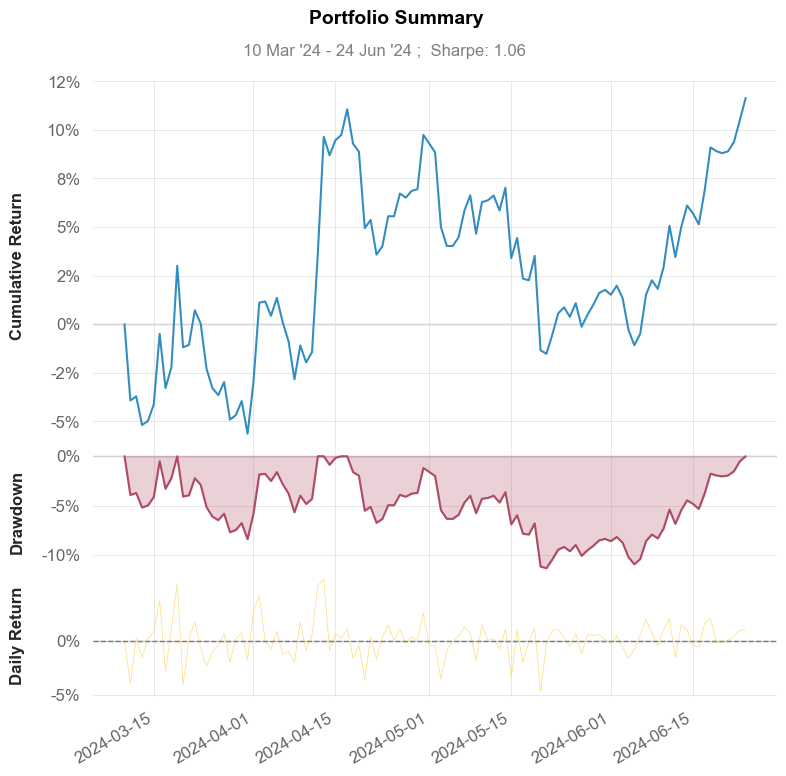

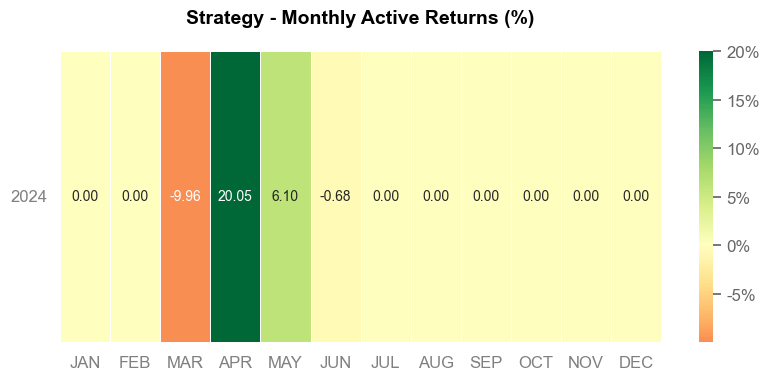

In [125]:
qs.reports.metrics(df['D_Transformer_CPD'],benchmark=df['baz'],mode='full')
qs.reports.plots(df['D_Transformer_CPD'],benchmark=df['baz'],mode='basic',benchmark_title = 'baz')

c:\Users\林元鴻\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\林元鴻\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\林元鴻\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old be

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2024-03-11   2024-03-11
End Period                 2024-06-24   2024-06-24
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          11.65%       -3.3%
CAGR﹪                     30.27%       -7.73%

Sharpe                     1.07         -0.41
Prob. Sharpe Ratio         75.6%        39.76%
Smart Sharpe               0.77         -0.29
Sortino                    1.61         -0.63
Smart Sortino              1.17         -0.45
Sortino/√2                 1.14         -0.44
Smart Sortino/√2           0.83         -0.32
Omega                      0.92         0.92

Max Drawdown               -11.33%      -8.29%
Longest DD Days            67           85
Volatility (ann.)          28.3%        16.33%
R^2                        0.7          0.7
Information Ratio          -0.05        -0.05
Calmar          

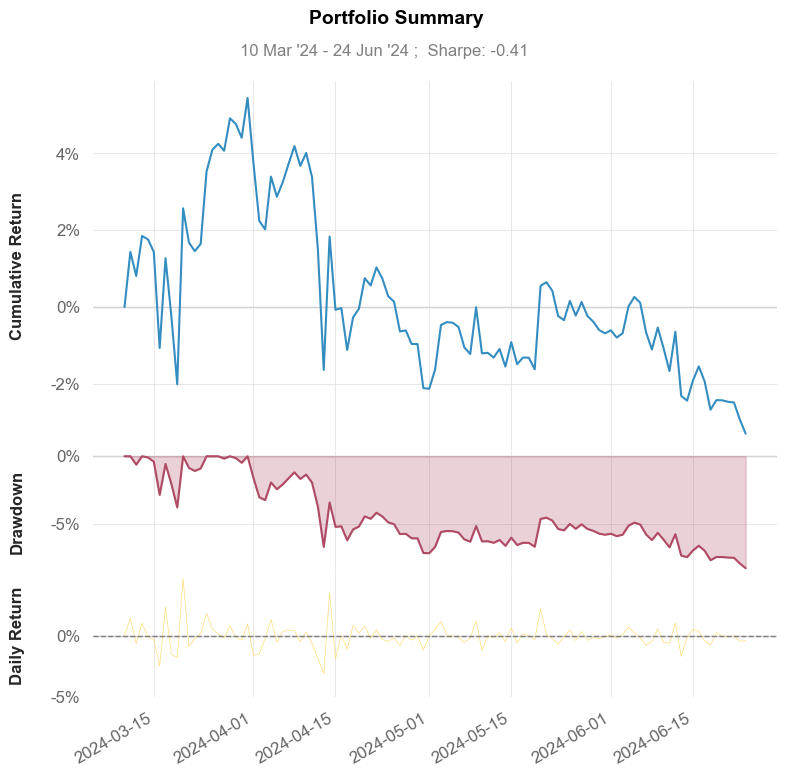

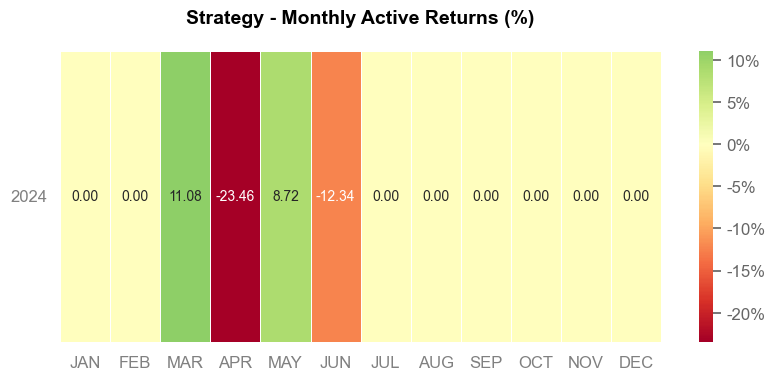

In [126]:
qs.reports.metrics(df['D_Transformer'],benchmark=df['D_Transformer_CPD'],mode='full')
qs.reports.plots(df['D_Transformer'],benchmark=df['D_Transformer_CPD'],mode='basic',benchmark_title = 'baz')

c:\Users\林元鴻\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\林元鴻\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\林元鴻\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old be

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2024-03-11   2024-03-11
End Period                 2024-06-24   2024-06-24
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          -3.97%       -3.79%
CAGR﹪                     -9.26%       -8.85%

Sharpe                     -0.17        -0.48
Prob. Sharpe Ratio         45.64%       38.04%
Smart Sharpe               -0.12        -0.35
Sortino                    -0.23        -0.73
Smart Sortino              -0.17        -0.53
Sortino/√2                 -0.16        -0.51
Smart Sortino/√2           -0.12        -0.37
Omega                      0.91         0.91

Max Drawdown               -19.01%      -8.71%
Longest DD Days            103          85
Volatility (ann.)          30.13%       16.41%
R^2                        0.0          0.0
Information Ratio          -0.01        -0.01
Calmar         

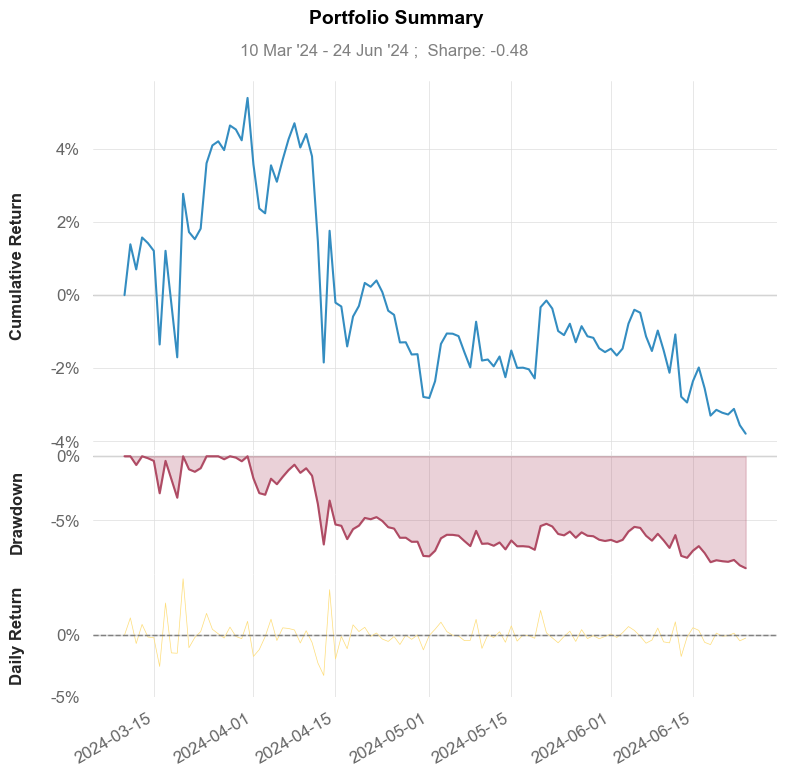

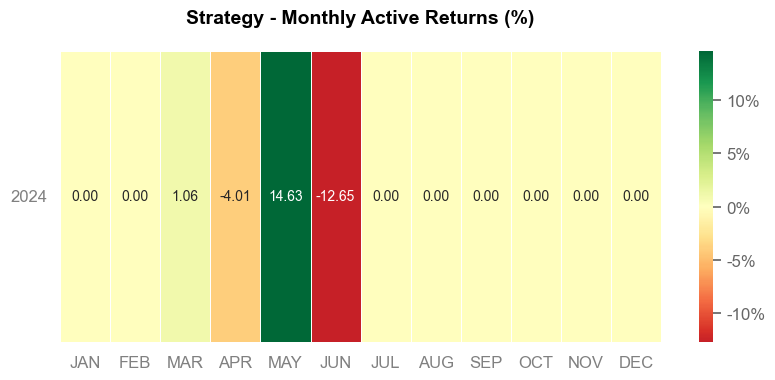

In [127]:
qs.reports.metrics(df['TFT'],benchmark=df['baz'],mode='full')
qs.reports.plots(df['TFT'],benchmark=df['baz'],mode='basic',benchmark_title = 'baz')

## Reference

[R1] Enhancing Time Series Momentum Strategies Using Deep Neural Networks [https://arxiv.org/pdf/1904.04912]\
[R2] Transformer Dissection: An Unified Understanding for Transformer’s Attention via the Lens of Kernel [https://aclanthology.org/D19-1443.pdf]\
[R3] How to Get Crypto Datas From bybit [https://www.codearmo.com/python-tutorial/getting-crypto-data-bybit]\
[R4] Temporal Fusion Transformers for Interpretable Multi-horizon Time Series Forecasting [https://arxiv.org/pdf/1912.09363]\
[R5] Trading with the Momentum Transformer: An Intelligent and Interpretable Architecture [https://arxiv.org/pdf/2112.08534]\
[R6] Attention Is All You Need [https://arxiv.org/pdf/1706.03762]\
[R7] Entity Embeddings of Categorical Variables [https://arxiv.org/pdf/1604.06737]